This notebook produces the figures used in the paper *"Do ocean dynamics contribute to coastal floods? A case study of the Shelfbreak Jet and coastal sea level along Southern New England (U.S.)"* by Camargo et al. (2025).

It requires as input data that has been saved in the script ```analysis.py```, which in turn uses:
- tide gauge data (```download_TG.py```)
- ERA5 data (```save_era5.py```)
- SBJ data (```get_save_data.py```)

Additionally, it also uses:
- hourly sea-level pressure from ERA5 from 2018-202 (to download go to https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=download) 
- wave data from the buoys (to download go to https://www.ndbc.noaa.gov/; wave buoy was compiled into a dictionary with ```save_waves.py```)
- dictionary with NOAA flood thresholds (```save_noaa_thresholds.py```)

Obs: Some figures with several panels have been compiled manually in ppt. 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
path_to_figures = '/Users/carocamargo/Documents/GitHub/FloodSBJ/figures/'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model

import seaborn as sns
import cmocean as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmcrameri as cmf
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm #, ListedColormap, 

# from utils_work import *

In [4]:
import string
letters = list(string.ascii_lowercase)

In [5]:
# reorderd by position in coastline from North to South
stations = [
            '8443970', # boston
#             '8447435',# chatam
            '8449130', # nantucket
            '8447930', # woods hole
            '8447386', # fall river
            '8452660', # Newport
            '8510560', # Montauk
            '8461490', # New London
            '8465705', # New Haven
            '8467150', # brigeport
            '8516945',# kings point
            '8531680', # sandy hook
            '8534720' # ; % Atlantic City, NJ
            ]

In [6]:
label_colors = {
               'MSL':'tab:red',
               'IB':'lightblue',
               'Tide':'tab:blue',
               'Total':'paleturquoise',
               'SBJ':'darkviolet',
    'Qy_bp':'darkviolet',
               'SBJ_h':'plum',
    'Qy_bp_h':'plum',
                'u_h':'peachpuff',
               'u':'darkorange',
               'v':'tab:green',
    'v_h':'aquamarine',
                'SS':'pink',
               'res':'lightgray',
    'overall':'tab:red'
               }

new_labels = {'SL_bp':'SS',
             'Q_bp':'SBJ',
             'tg':'Total',
             'lf':'MSL',
             'tide':'Tide',
             'ib':'IB'}

labelsize=20
ticksize=18
legendsize=18
titlesize=22

# Open data

In [7]:
from utils_work import open_dict

In [8]:
path = '/Users/carocamargo/Documents/data/floodSBJ/'
filename = 'SBJ_SS_regressions_ridge_1000_norm' # see prep_data_plotting.py
hilb=False
if hilb:
    filename = filename+'_hilb'

# filename = 'SBJ_SS_regressions_ridge_1000_minorflood_norm'
dic = open_dict(path,filename)


In [9]:
# tide gauges
# path_save = '/Users/carocamargo/Documents/data/sealevel/'
outname = 'df_sl_dic_bp_mhhw'
    
dfs_sl = open_dict(path,outname,)
names = [dfs_sl[stations[i]]['dic']['name'] for i,_ in enumerate(stations)]


In [10]:
NS = len(stations)

# Regression Coef

In [11]:
params = ['SBJ','u','v']

## Scatter

In [12]:
markers = ['o','s','^']

In [13]:
if hilb: 
    params = params + [ 'Qy_bp_h', 'u_h', 'v_h']
    markers = markers + ['*','P','D']

Only with units of SL:

In [14]:
labels ={'SBJ':'Q',
        'Qy_bp':'Q',
        'u':r'$\tau_x$',
        'v':r'$\tau_y$',
         'overall':'Total'
        }

In [15]:
line=False

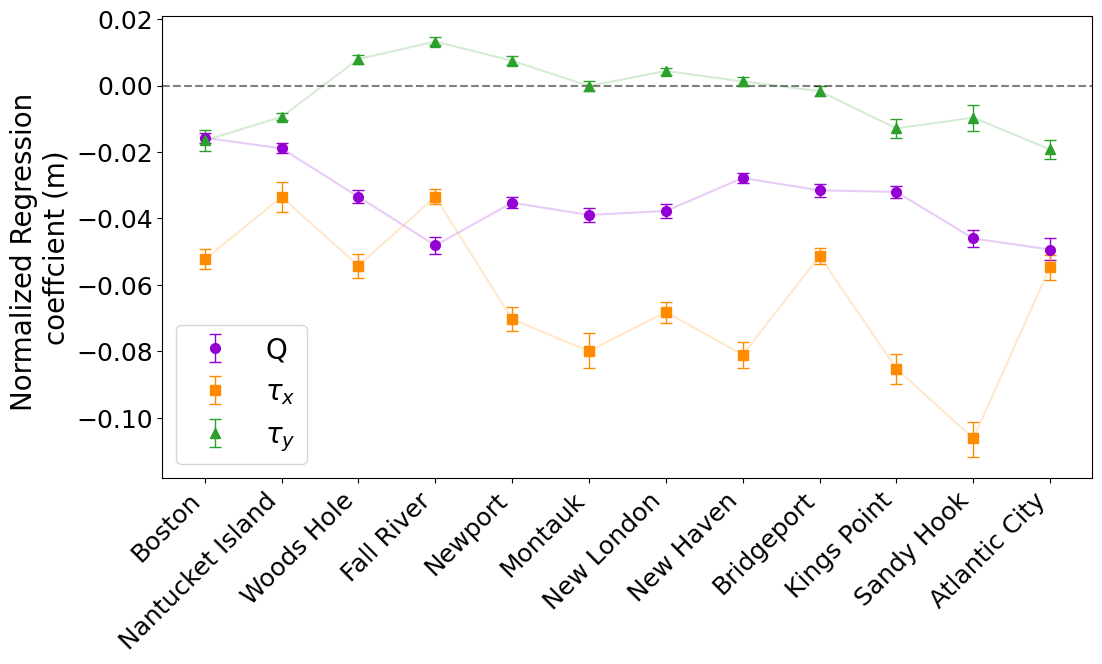

In [16]:

fig = plt.figure(figsize=(12,6))
for j,param in enumerate(params):
    coefs = np.zeros((NS))
    med_coefs = np.zeros((NS))
    ci_u = np.zeros((NS))
    ci_l = np.zeros((NS))
    ci_w = np.zeros((NS))
    for i, station in enumerate(stations):
        xstd = np.std(dic[station]['original']['X'][j])
        coefs[i] = np.array(dic[station]['original']['slope'][j] * xstd)
        med_coefs[i] = dic[station]['bootstrap']['stats_slope']['med'][j]* xstd
        ci_l[i] = dic[station]['bootstrap']['stats_slope']['cis'][j][0]* xstd
        ci_u[i] = dic[station]['bootstrap']['stats_slope']['cis'][j][1]* xstd
        ci_w[i] = dic[station]['bootstrap']['stats_slope']['ci_widths'][j]* xstd
    if param=='Qy_bp':
        param = 'SBJ'  
    
    plt.plot(stations,coefs,c=label_colors[param],alpha=0.2)
    
    if line:
        plt.scatter(stations,coefs,
                    label=labels[param],
                # linewidth=lw,
                    marker=markers[j],
                    # marker = 'o',
                    s=70,
                 c=label_colors[param])
        #     # Shaded confidence interval
        plt.fill_between(stations, 
                         ci_l,ci_u,

                         color=label_colors[param], alpha=0.2)
    
    else:
        yerr = [coefs - ci_l, ci_u - coefs]

        plt.errorbar(
            stations, coefs,
            yerr=yerr,
            fmt=markers[j],                # marker style
            label=labels[param],
            color=label_colors[param],
            markersize=7,
            capsize=4,                     # length of error bar caps
            elinewidth=1,                 # line width of error bars
        )


# 
    

#     print(r2s[i,2])
# print(sum(r2s[0:3,2]))
plt.ylabel('Normalized Regression \ncoeffcient (m)',fontsize=labelsize)
plt.legend(fontsize=labelsize)
# plt.xlabel('Stations')
plt.xticks(np.arange(len(stations)),names,rotation=45,ha='right',fontsize=ticksize)
# plt.title('Regression Coefficient',fontsize=titlesize)
# plt.ylim(-0.7,0.2)

plt.axhline(0,color='black',linestyle='--',alpha=0.5)
plt.yticks(fontsize=ticksize)

plt.show()


In [17]:
kurs=path_to_figures+'regression_coefs_norm.png'
            
fig.savefig(kurs,format='png',dpi=300,bbox_inches='tight')

# Explained Variance

## All dates

In [18]:
params = ['overall','Qy_bp','u','v']

In [19]:
markers = ['D','o', 's', '^']

In [20]:
line=False

overall: 61.343
Qy_bp: 28.411
u: 37.667
v: 2.833


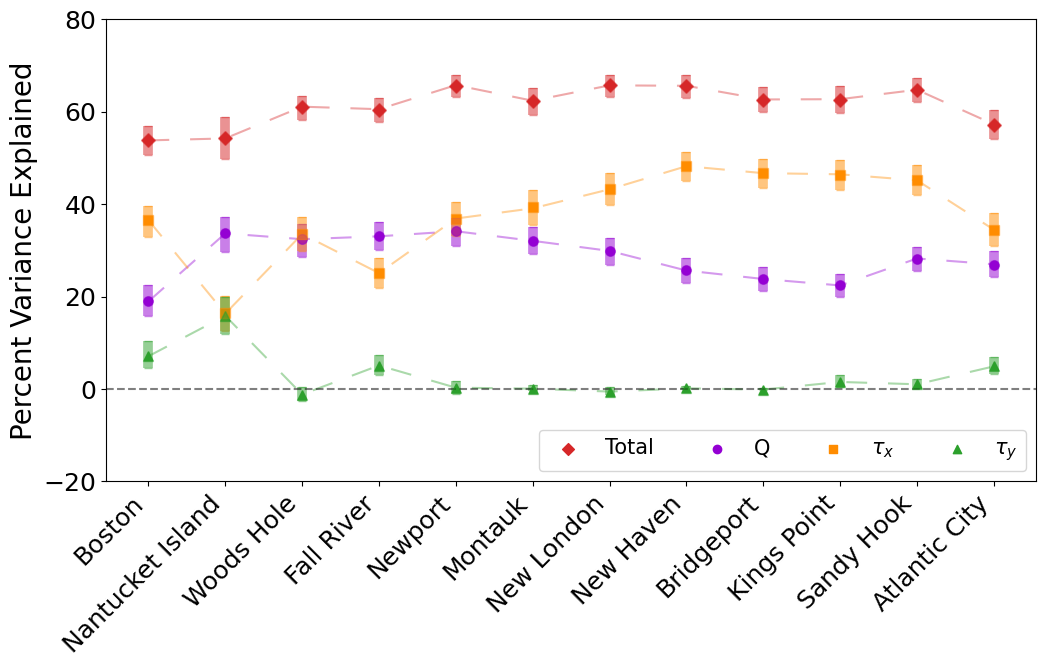

In [21]:
fig = plt.figure(figsize=(12,6))

if hilb:
    
    for j,param in enumerate(params):
        coefs = np.zeros((NS))
        med_coefs = np.zeros((NS))
        ci_u = np.zeros((NS))
        ci_l = np.zeros((NS))
        ci_w = np.zeros((NS))
        for i, station in enumerate(stations):
            if param != 'overall':
                paramh = param+'_h'
                h = j+3
                coefs[i] = np.sum([dic[station]['original']['r2s'][param] * 100,
                                    dic[station]['original']['r2s'][paramh] * 100,
                                   ])
                med_coefs[i] = np.sum([dic[station]['bootstrap']['stats_r2']['med'][j]* 100,
                                       dic[station]['bootstrap']['stats_r2']['med'][h]* 100,
                                      ])
                ci_l[i] = np.sum([dic[station]['bootstrap']['stats_r2']['cis'][j][0]* 100,
                                  dic[station]['bootstrap']['stats_r2']['cis'][h][0]* 100,
                                 ])
                ci_u[i] = np.sum([dic[station]['bootstrap']['stats_r2']['cis'][j][1]* 100,
                                  dic[station]['bootstrap']['stats_r2']['cis'][h][1]* 100,
                                 ])
                ci_w[i] = np.sum([dic[station]['bootstrap']['stats_r2']['ci_widths'][j]* 100,
                                  dic[station]['bootstrap']['stats_r2']['ci_widths'][h]* 100,
                                 ])
            else:
                coefs[i] = dic[station]['original']['r2s'][param] * 100
                med_coefs[i] = dic[station]['bootstrap']['stats_r2']['med'][j]* 100
                ci_l[i] = dic[station]['bootstrap']['stats_r2']['cis'][j][0]* 100
                ci_u[i] = dic[station]['bootstrap']['stats_r2']['cis'][j][1]* 100
                ci_w[i] = dic[station]['bootstrap']['stats_r2']['ci_widths'][j]* 100
        if param=='Qy_bp':
            param = 'SBJ'
    #     plt.scatter(stations,coefs,
    #                 label=param,
    #             # linewidth=lw,
    #                 marker=markers[j],
    #                 # marker = 'o',
    #                 s=70,
    #              c=label_colors[param])
        plt.plot(stations,coefs,'-o',c=label_colors[param],alpha=0.5,label=labels[param])
        print('{}: {:.3f}'.format(param, np.mean(coefs,axis=0)))

        plt.plot(stations,med_coefs,'--',c=label_colors[param],alpha=0.5,label='bootstrap median')

    #     # Shaded confidence interval
        plt.fill_between(stations, 
                         ci_l,ci_u,

                         color=label_colors[param], alpha=0.2,label='95% CI')
    #     print(r2s[i,2])
    # print(sum(r2s[0:3,2]))
    plt.ylabel('(%)',fontsize=labelsize)
    plt.legend(ncol=4,loc='lower right',fontsize=10)
    # plt.xlabel('Stations')
    plt.xticks(np.arange(len(stations)),names,rotation=45,ha='right',fontsize=ticksize)
    plt.title('All days of each station',fontsize=titlesize)
    plt.ylim(-20,80)
    plt.axhline(0,color='black',linestyle='--',alpha=0.5)
    plt.yticks(fontsize=ticksize)
    plt.show()
else:
    for j,param in enumerate(params):
        coefs = np.zeros((NS))
        med_coefs = np.zeros((NS))
        ci_u = np.zeros((NS))
        ci_l = np.zeros((NS))
        ci_w = np.zeros((NS))
        for i, station in enumerate(stations):
            coefs[i] = dic[station]['original']['r2s'][param] * 100
            med_coefs[i] = dic[station]['bootstrap']['stats_r2']['med'][j]* 100
            ci_l[i] = dic[station]['bootstrap']['stats_r2']['cis'][j][0]* 100
            ci_u[i] = dic[station]['bootstrap']['stats_r2']['cis'][j][1]* 100
            ci_w[i] = dic[station]['bootstrap']['stats_r2']['ci_widths'][j]* 100
#         if param=='Qy_bp':
#             param = 'Q'
        plt.plot(stations,med_coefs,linestyle=(0, (10, 10)),c=label_colors[param],alpha=0.4,
#                  label='bootstrap median'
                 )
        print('{}: {:.3f}'.format(param, np.mean(coefs,axis=0)))
        
        if line:
            plt.plot(stations,coefs,'-o',c=label_colors[param],alpha=0.5,
        #              label=param
                      label='{} ({:.0f}%)'.format(labels[param],np.mean(coefs,axis=0))

                    )



            # Shaded confidence interval
            plt.fill_between(stations, 
                             ci_l,ci_u,

                             color=label_colors[param], alpha=0.2,
    #                          label='95% CI'
                            )
        else:
            yerr = [coefs - ci_l, ci_u - coefs]

            plt.errorbar(
                stations, coefs,
                yerr=yerr,
                fmt=markers[j],                # marker style
#                 label=labels[param],
                color=label_colors[param],
                alpha=0.5,
                markersize=7,
                capsize=3,                     # length of error bar caps
                elinewidth=7,                 # line width of error bars
            )
            plt.scatter(stations,coefs,color=label_colors[param],
                        marker=markers[j], 
                       label=labels[param])
#             plt.fill_between(stations, 
#                              ci_l,ci_u,

#                              color=label_colors[param], alpha=0.2,
#     #                          label='95% CI'
#                             )

    #     print(r2s[i,2])
    # print(sum(r2s[0:3,2]))
    plt.ylabel('Percent Variance Explained',fontsize=labelsize)
    plt.legend(ncol=4,loc='lower right',fontsize=15)
    # plt.xlabel('Stations')
    plt.xticks(np.arange(len(stations)),names,rotation=45,ha='right',fontsize=ticksize)
#     plt.title('All days of each station',fontsize=titlesize)
    plt.ylim(-20,80)
    plt.axhline(0,color='black',linestyle='--',alpha=0.5)
    plt.yticks(fontsize=ticksize)
    plt.show()

In [22]:
kurs=path_to_figures+'var_explained_alldays.png'
            
fig.savefig(kurs,format='png',dpi=300,bbox_inches='tight')

## All flood days 

If Hilbert, plot sum of param + hilb

overall: 64.220
SBJ: 24.850
u: 28.344
v: 3.923


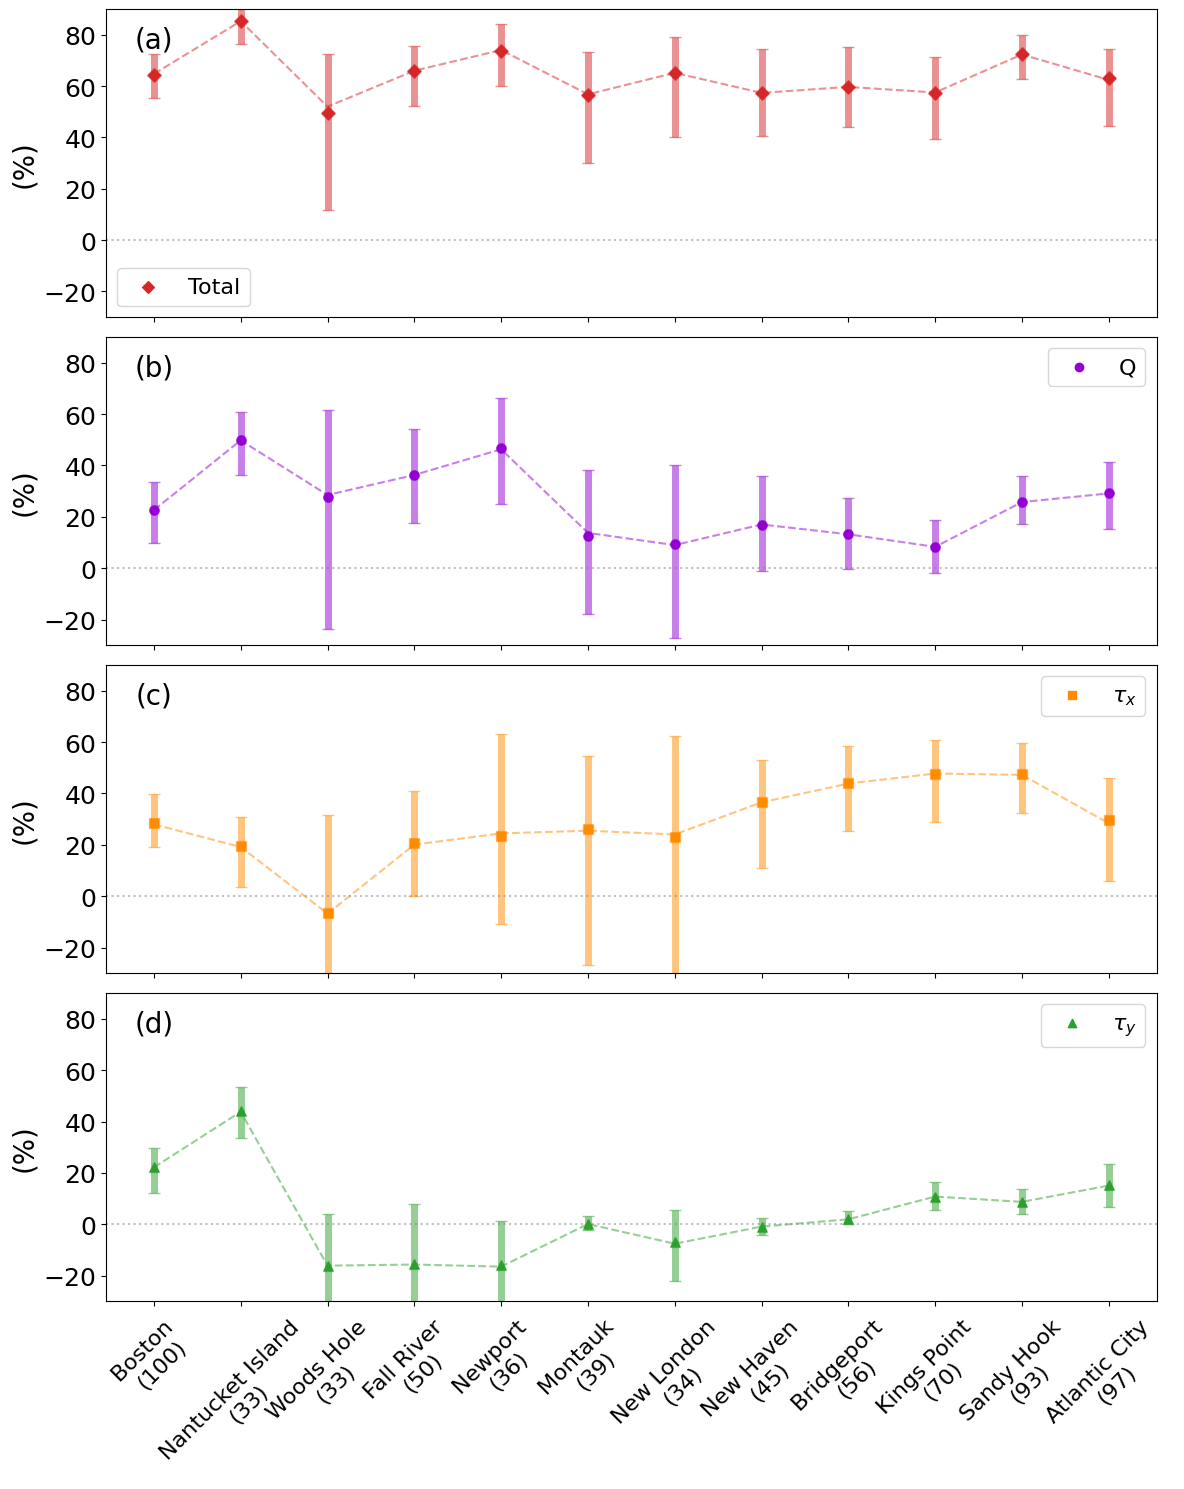

In [23]:
# fig = plt.figure(figsize=(15,6))
fig = plt.figure(figsize=(12,15))
for j,param in enumerate(params):
    coefs = np.zeros((NS))
    med_coefs = np.zeros((NS))
    ci_u = np.zeros((NS))
    ci_l = np.zeros((NS))
    ci_w = np.zeros((NS))
    nf = np.zeros((NS))
    ns = []
    ax = plt.subplot(4,1,int(j+1))
    for i, station in enumerate(stations):
        if hilb:
            if param != 'overall':
                paramh = param+'_h'
                h = j+3
                coefs[i] = np.sum([dic[station]['original']['r2s_floods'][param] * 100,
                                    dic[station]['original']['r2s_floods'][paramh] * 100,
                                   ])
                med_coefs[i] = np.sum([dic[station]['bootstrap']['stats_r2_flood']['med'][j]* 100,
                                       dic[station]['bootstrap']['stats_r2_flood']['med'][h]* 100,
                                      ])
                ci_l[i] = np.sum([dic[station]['bootstrap']['stats_r2_flood']['cis'][j][0]* 100,
                                  dic[station]['bootstrap']['stats_r2_flood']['cis'][h][0]* 100,
                                 ])
                ci_u[i] = np.sum([dic[station]['bootstrap']['stats_r2_flood']['cis'][j][1]* 100,
                                  dic[station]['bootstrap']['stats_r2']['cis'][h][1]* 100,
                                 ])
                ci_w[i] = np.sum([dic[station]['bootstrap']['stats_r2_flood']['ci_widths'][j]* 100,
                                  dic[station]['bootstrap']['stats_r2_flood']['ci_widths'][h]* 100,
                                 ])
            else:
                coefs[i] = dic[station]['original']['r2s_floods'][param] * 100
                med_coefs[i] = dic[station]['bootstrap']['stats_r2_flood']['med'][j]* 100
                ci_l[i] = dic[station]['bootstrap']['stats_r2_flood']['cis'][j][0]* 100
                ci_u[i] = dic[station]['bootstrap']['stats_r2_flood']['cis'][j][1]* 100
                ci_w[i] = dic[station]['bootstrap']['stats_r2_flood']['ci_widths'][j]* 100
                nf[i] = dic[station]['original']['n_flood']
        else:
            coefs[i] = dic[station]['original']['r2s_floods'][param] * 100
            med_coefs[i] = dic[station]['bootstrap']['stats_r2_flood']['med'][j]* 100
            ci_l[i] = dic[station]['bootstrap']['stats_r2_flood']['cis'][j][0]* 100
            ci_u[i] = dic[station]['bootstrap']['stats_r2_flood']['cis'][j][1]* 100
            ci_w[i] = dic[station]['bootstrap']['stats_r2_flood']['ci_widths'][j]* 100
            nf[i] = dic[station]['original']['n_flood']
            
        ns.append('{} \n({})'.format(names[i],int(nf[i])))
    if param=='Qy_bp':
        param = 'SBJ'
    plt.plot(stations,med_coefs,'--',c=label_colors[param],alpha=0.5,
#                  label='bootstrap median'
             )
    print('{}: {:.3f}'.format(param, np.mean(coefs,axis=0)))

    if line:
        plt.plot(stations,coefs,'-o',c=label_colors[param],alpha=0.5,
    #              label=param
                  label='{} ({:.0f}%)'.format(labels[param],np.mean(coefs,axis=0))

                )



        # Shaded confidence interval
        plt.fill_between(stations, 
                         ci_l,ci_u,

                         color=label_colors[param], alpha=0.2,
#                          label='95% CI'
                        )
    else:
        yerr = [coefs - ci_l, ci_u - coefs]

        plt.errorbar(
            stations, coefs,
            yerr=yerr,
            fmt=markers[j],                # marker style
#                 label=labels[param],
            color=label_colors[param],
            alpha=0.5,
            markersize=7,
            capsize=4,                     # length of error bar caps
            elinewidth=5,                 # line width of error bars
        )
        plt.scatter(stations,coefs,color=label_colors[param],
                    marker=markers[j], 
                   label=labels[param])
#     print(r2s[i,2])
# print(sum(r2s[0:3,2]))
#     plt.ylabel('{} (%)'.format(param),fontsize=labelsize)
    plt.ylabel('(%)',fontsize=labelsize)
    

#     plt.legend(ncol=2,loc='lower right',fontsize=10)
# plt.xlabel('Stations')
    if j==len(params)-1:
        plt.xticks(np.arange(len(stations)),ns,rotation=45,ha='center',fontsize=ticksize-2)
#         plt.legend(ncol=2,loc='upper right',fontsize=12)

    else:
        plt.xticks(np.arange(len(stations)),'')
#         plt.legend(ncol=2,loc='lower right',fontsize=12)
    plt.legend(fontsize=ticksize-2)
#     if j ==0:
#         plt.title('Variance explained for all flood days of each station',fontsize=titlesize)
    
    ax.text(stations[0], 75,'({})'.format(letters[j]), ha='center', fontsize=labelsize)

    plt.ylim(-30,90)
    plt.axhline(0,color='gray',linestyle=':',alpha=0.5)
    plt.yticks(fontsize=ticksize)
plt.tight_layout()
plt.show()

In [24]:
kurs=path_to_figures+'var_explained_flooddays.png'
            
fig.savefig(kurs,format='png',dpi=300,bbox_inches='tight')

# Expected Flood Days

In [26]:
datum = 'MHHW'
thresholds = open_dict(path,'noaaFlood_MHHW')

In [27]:
colors = ['deepskyblue','purple','red','lightgray','lightgray']
linestyles = ['-','--',':','--','--']

In [28]:
ND = len(dic[station]['original']['Y'])
TGs = np.zeros((NS,ND))

In [29]:
col_labels = {'SL_TG':'Tide gauge',
             'SL_noSBJ':'No SBJ',
             'SL_noSS': 'No SS'}

In [30]:

def read_threshold_CP25(
        stations = ['8443970',
         '8449130',
         '8447930',
         '8447386',
         '8452660',
         '8510560',
         '8461490',
         '8465705',
         '8467150',
         '8516945',
         '8531680',
         '8534720'],
        path = '/Users/carocamargo/Documents/data/thresholds/'
        ):
    
    
    file = 'data.xls'
    data = pd.read_excel(path+file,header=None,
                       names=['name','region','id','lat','lon',
                                'nws_minor','nos_minor'])
    # Ensure the id column is string type
    data['id'] = data['id'].astype(str)


    # Filter the DataFrame
    data_sel = data[data['id'].isin(stations)]
    
    
    file = 'thresholds.xls'
    
    df = pd.read_excel(path+file,header=None,names=data['id'])
    df2 = df[stations]

    return data,df2

data,df2 = read_threshold_CP25()

Boston: 100
Nantucket Island: 33
Woods Hole: 33
Fall River: 50
Newport: 36
Montauk: 39
New London: 34
New Haven: 45
Bridgeport: 56
Kings Point: 70
Sandy Hook: 93
Atlantic City: 97


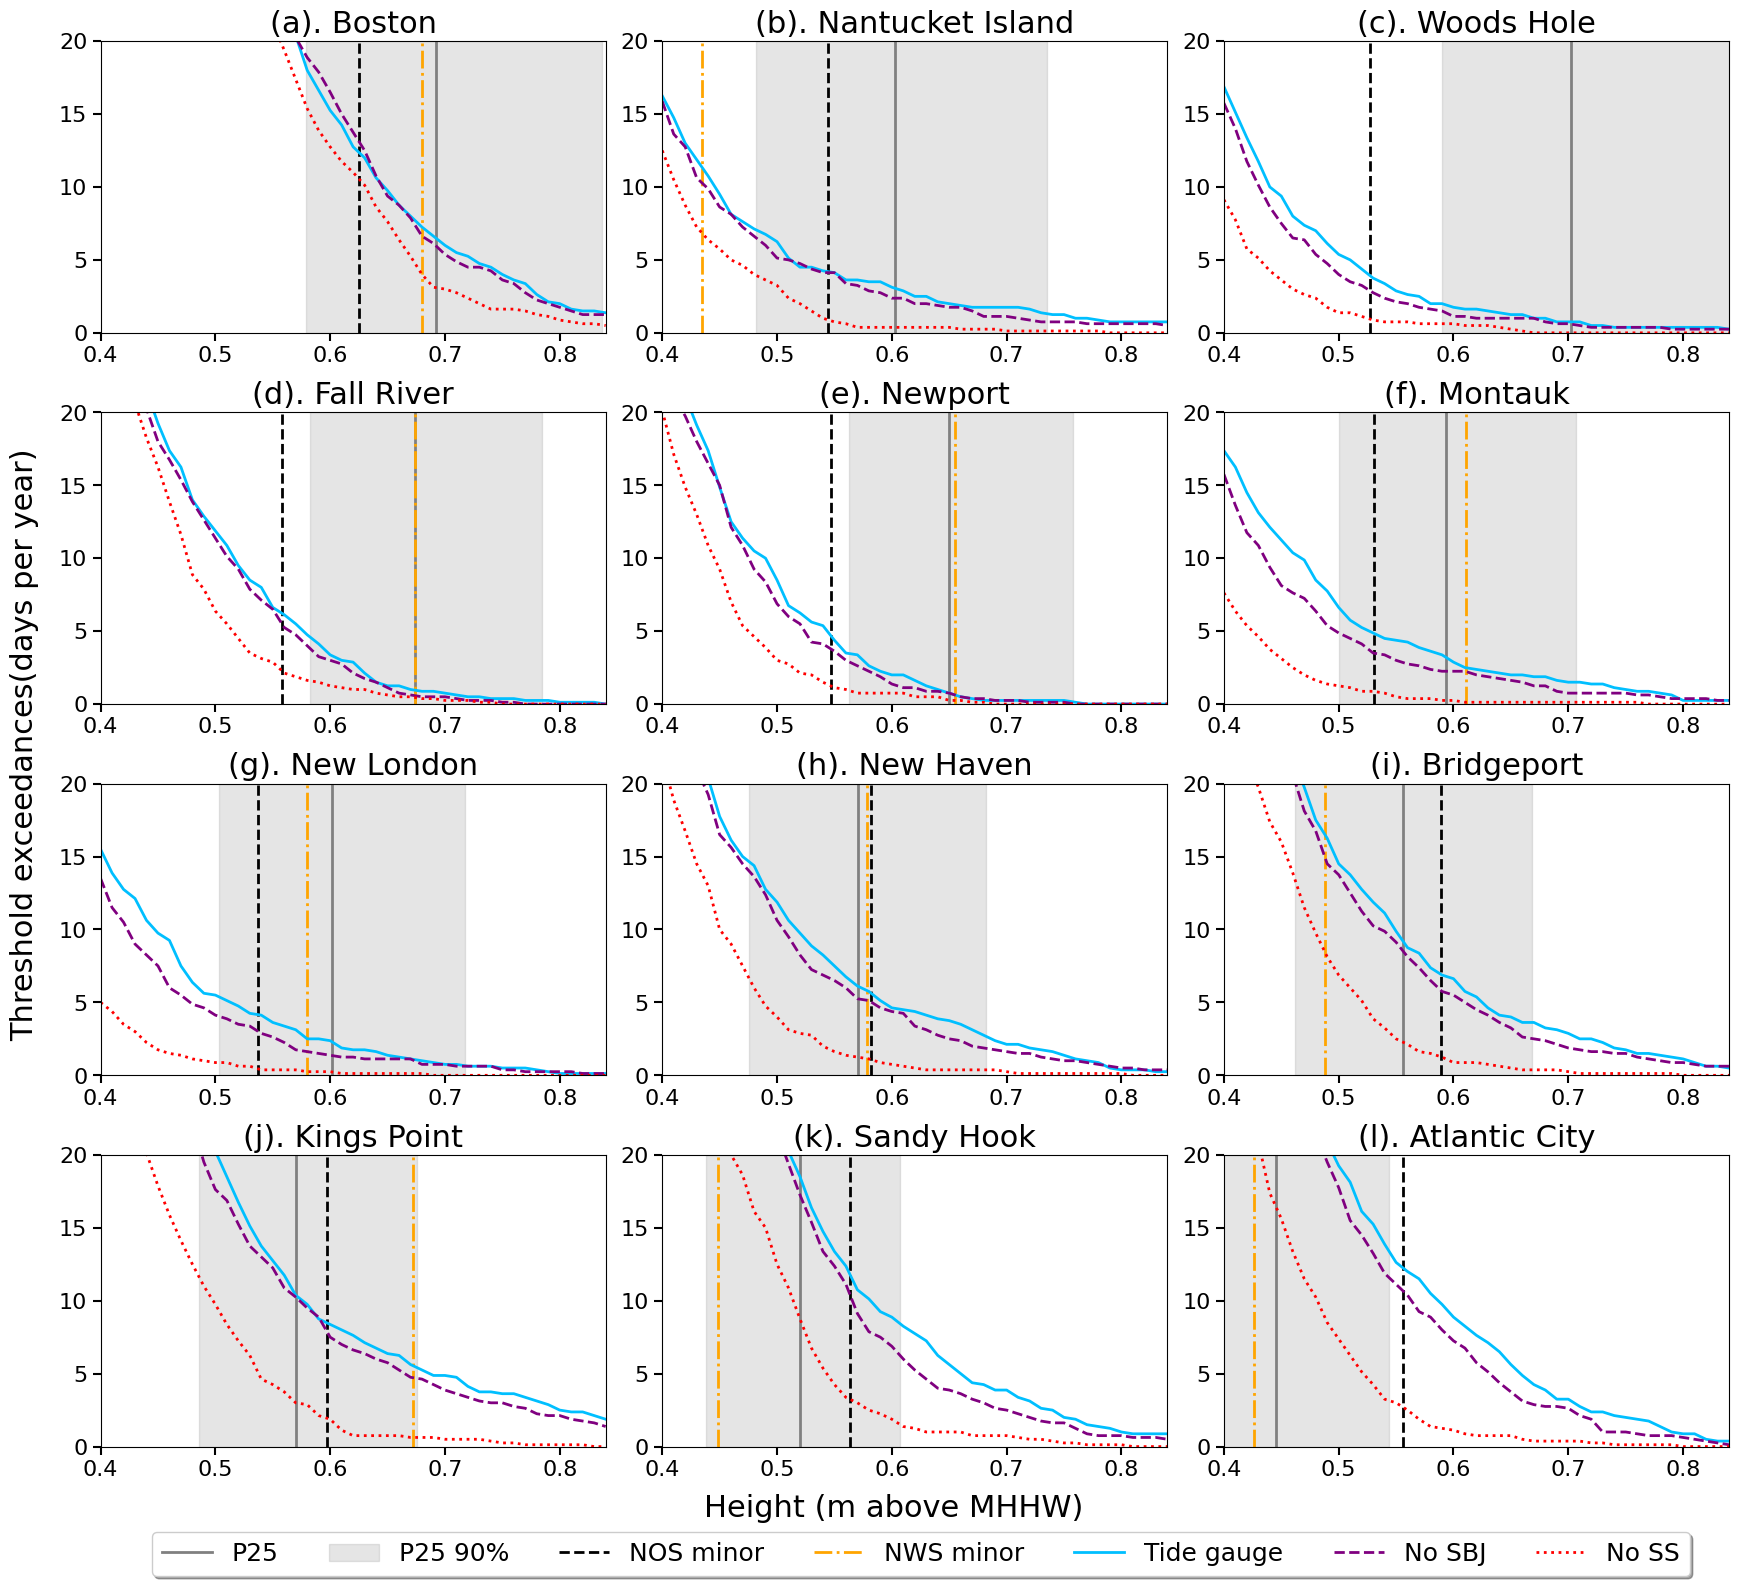

In [31]:
cont_thresholds = np.arange(0.4,0.85,0.01)
nyears=len(np.arange(2015,2022+1,1))
nrow=4;ncol=3
fig = plt.figure(figsize=(17,15))
for i,station in enumerate(stations):
    name = dfs_sl[station]['dic']['name']
    # organize df and resample to daily max
    da = dfs_sl[station]['df']
    if 'time' in da.columns:
        da['time']=pd.to_datetime(da['time'])
    else:
        da['time'] = pd.to_datetime(da.index)
    da.set_index('time',inplace=True)            
    da = da.resample('1D').apply(lambda x: x.loc[x['SL_tg'].idxmax()])
    
    # get variables we want
    TG = np.array(da['SL_tg'])
    TGs[i,:] = np.array(TG)
    HF=np.array(da['SL_cor']-da['SL_bp'])
    tide_IB = np.array(da['tide']+da['ib'])
    SS = np.array(da['SL_bp'])

    s = dic[station]['original']['slope']
    X = dic[station]['original']['X']
    SS_recons = np.array(X @ s)

    SS_res = np.array(SS-SS_recons)

    j=0
    SS_SBJ = np.array(X[:,j] * s[j])
    if hilb:
        j=3
        SS_SBJ_h = np.array(X[:,j] * s[j])
        SS_SBJ = np.array(SS_SBJ + SS_SBJ_h)

    SL_nojet = np.array(tide_IB + HF + SS_res + (SS_recons - SS_SBJ) )
    SL_noSS = np.array(tide_IB + HF) 
    
    # make df
    dd = pd.DataFrame({'SL_TG':TG,
                      'SL_noSS':SL_noSS,
                      'SL_noSBJ':SL_nojet
                      })
    thres = thresholds[station]['nos_minor']
    thres2 = thresholds[station]['nws_minor']
    dft = df2[station]
    x = np.array(df2[station])
    thres_min = np.quantile(x,0.05)
    thres_max = np.quantile(x,0.95)
    thres_med = np.median(x)
    
    nf = len(TG[TG>thres])
    print('{}: {}'.format(name,nf))
    

    dd = pd.DataFrame({'SL_TG':TG,
                      'SL_noSS':SL_noSS,
                      'SL_noSBJ':SL_nojet,
                   'time':da.index
                      })
    dd.set_index('time',inplace=True)
    
    data = {}
    # thresholds = np.arange(0.8,1.81,0.1)
        # Loop over each threshold
    for threshold in cont_thresholds:
        exc_count = {}
    #     print(threshold)
        for lb in ['SL_TG','SL_noSBJ','SL_noSS',]:
            # days of exceedance
            exceedance_days = dd[dd[lb] > threshold]

            # how many days per year is exceeded
            annual_counts = exceedance_days.groupby(exceedance_days.index.year).size()

            mean_exceedance = annual_counts.mean()  # Calculate the mean
            mean_exceedance = len(exceedance_days)/nyears 
            exc_count[lb] = mean_exceedance
    #         print(exc_count[lb])
        data[threshold] = exc_count

    dfe = pd.DataFrame(data)
    dfe.replace(np.nan,0,inplace=True)
    dfe = dfe.T
    dfe

    ## PLOT
    ax = plt.subplot(nrow,ncol,int(i+1))
    
    ## thresholds
    plt.axvline(thres_med,linewidth=2,c='gray',label='P25',linestyle='-')
    plt.fill_betweenx([0,20], thres_min, thres_max, color='gray', alpha=0.2,label='P25 90%')
    plt.axvline(thres,linewidth=2,c='black',label='NOS minor',linestyle='--')
    plt.axvline(thres2,linewidth=2,c='orange',label='NWS minor',linestyle='-.')
#     plt.axvline(thres_min,linewidth=2,c='red',label='NWS minor',linestyle='-')

    for j,col in enumerate(dfe.columns):
        plt.plot(dfe.index,dfe[col],
                  label=col_labels[col],
                 linewidth=2,
                 linestyle=linestyles[j],
                 c=colors[j],
                 # c='gray',
    #                  alpha=0.5
                )
    plt.xlim(0.4,0.84)
    plt.ylim(0,20)
            
    plt.title('({}). {}'.format(letters[i],name),fontsize=titlesize)

#     plt.grid()
    plt.yticks(np.arange(0,25,5),fontsize=ticksize-2)
    plt.xticks(np.arange(0.4,0.81,0.1),fontsize=ticksize-2)
    ax.tick_params(axis='both', length=6, width=1.5)  # default is ~3.5 length, ~0.8 width


    # remove tick labels of the inside panels
#     if i%3!=0:
#         ax.set_yticklabels([])
#     if i<9:
#         ax.set_xticklabels([])

# Put a single label
fig.text(0.5, -0.015, 'Height (m above MHHW)', ha='center', fontsize=titlesize)
fig.text(-0.02, 0.5, 'Threshold exceedances(days per year)', va='center', 
         rotation='vertical', fontsize=titlesize)

plt.tight_layout()
# Add legend outside plot
plt.legend(loc='upper center', bbox_to_anchor=(-0.6, -0.25),
           fontsize=legendsize,
          ncol=7, fancybox=True, shadow=True)
plt.show()


In [32]:
kurs=path_to_figures+'exceedance_days.png'
            
fig.savefig(kurs,format='png',dpi=300,bbox_inches='tight')

In percentage:

In [33]:
days = dd.index


# Bar plot

In [34]:
mar18_dates = pd.to_datetime([
#     '2018-03-02', 
                              '2018-03-03', '2018-03-04', 
                        '2018-03-05', '2018-03-06', 
#                               '2018-03-07'
                             ])

# Bars

In [35]:
label_colors = {'MSL': 'tab:red',
 'IB': 'lightblue',
 'Tide': 'tab:blue',
 'Total': 'palegoldenrod',
 'SBJ': 'darkviolet',
 'Q': 'darkviolet',                
 'SBJ_h': 'plum',
 'Qy_bp_h': 'plum',
 'u_h': 'peachpuff',
 'u': 'darkorange',
 'v': 'tab:green',
 r'$\tau_x$': 'darkorange',
 r'$\tau_y$': 'tab:green',
 'v_h': 'aquamarine',
 'SS': 'pink',
 'res': 'lightgray',
 'residual': 'lightgray',
                
 'overall': 'tab:red'}

Notations indicate if we had a flood based on observed water level (TG,star) and if observeled level without the influence of the SBJ (TG-SBJ,triangle). That is, names with both star and triangle means we had a flood and would keep having a flood, even if we remove SBJ dynamics. Places with a star and no triangle means that the observed flood would not have happened without the SBJ dynamics. Stations without any notations means there was no observed flood. 

If Hilbert, then each paramter is the sum of the original+ transform

## March 2018

2018-03-03 00:00:00
Mean exceedance: 0.25
Total       0.817083
MSL         0.416743
Tide        0.155170
IB         -0.010199
SS          0.260201
overall     0.115428
Q           0.115151
$\tau_x$   -0.004167
$\tau_y$    0.004445
residual    0.144773
no_SBJ      0.701933
dtype: float64
2018-03-04 00:00:00
Mean exceedance: 0.22
Total       0.783500
MSL         0.406399
Tide        0.141074
IB         -0.067312
SS          0.294550
overall     0.169407
Q           0.163994
$\tau_x$    0.004181
$\tau_y$    0.001232
residual    0.125144
no_SBJ      0.619506
dtype: float64
2018-03-05 00:00:00
Mean exceedance: 0.03
Total       0.593250
MSL         0.423056
Tide        0.115360
IB         -0.049449
SS          0.097129
overall     0.093254
Q           0.115196
$\tau_x$   -0.027254
$\tau_y$    0.005311
residual    0.003875
no_SBJ      0.478054
dtype: float64
2018-03-06 00:00:00
Mean exceedance: 0.08
Total       0.641750
MSL         0.426184
Tide        0.057634
IB         -0.059664
SS        

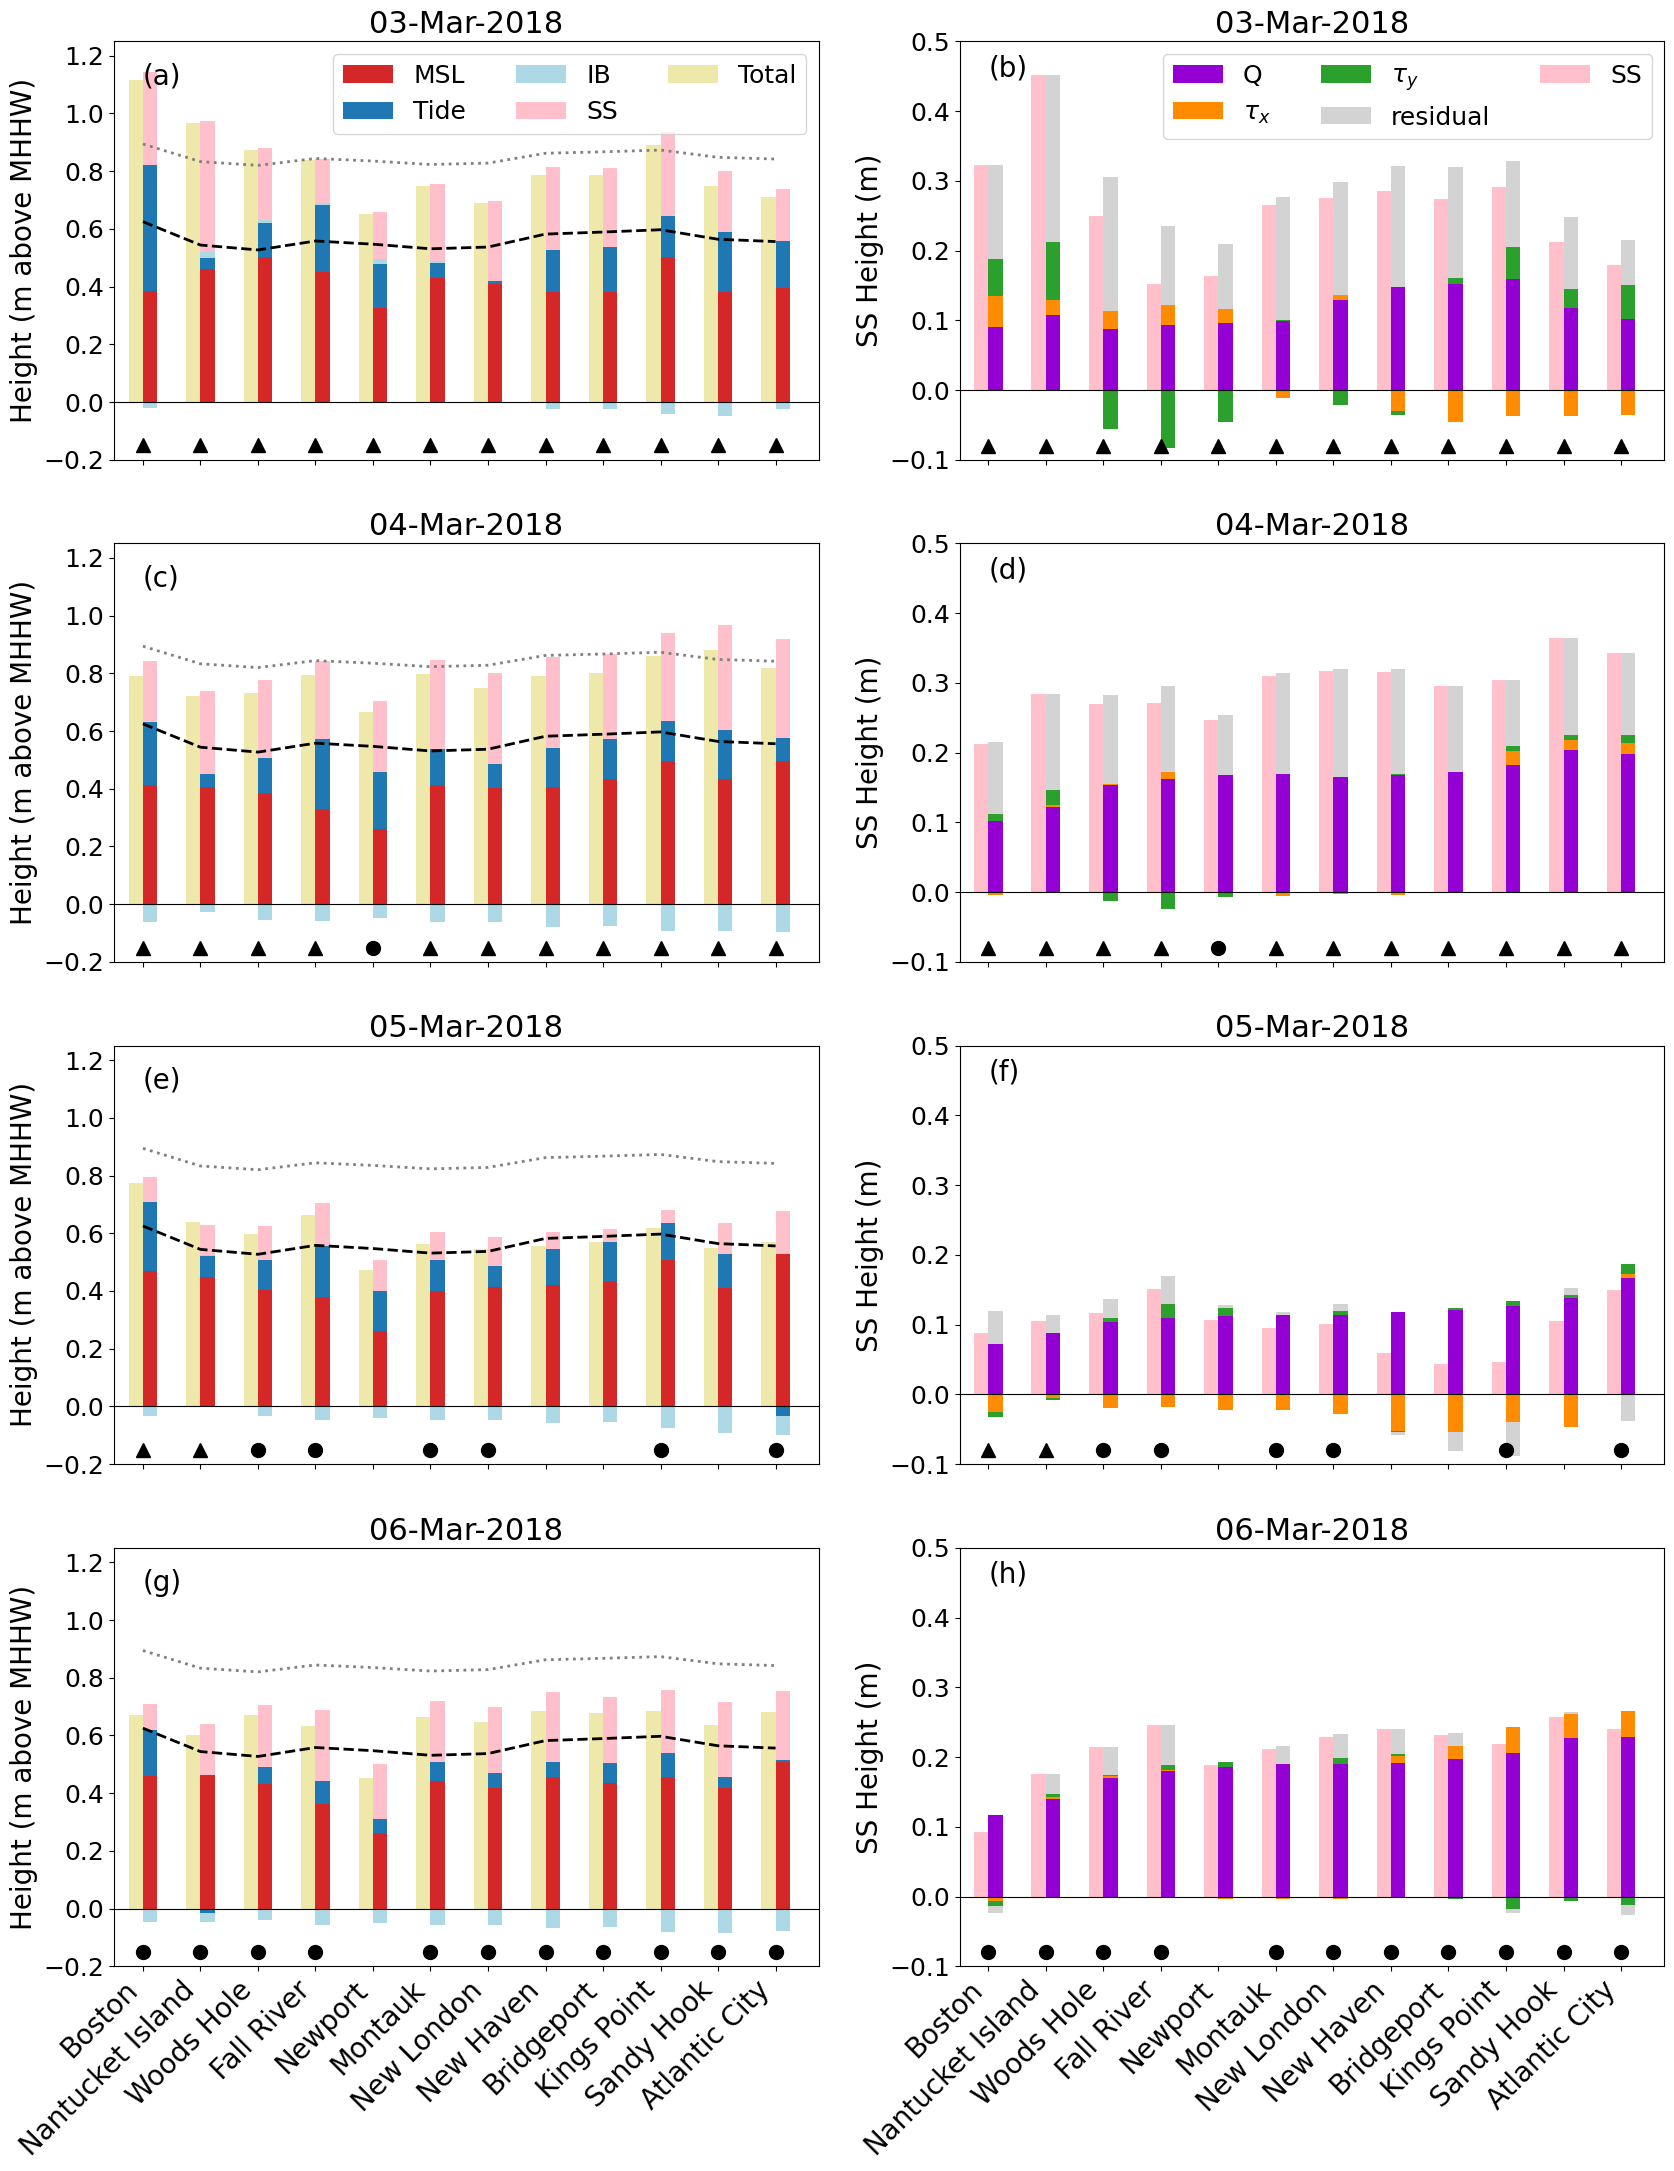

In [36]:
fig =  plt.figure(figsize=(20,25))
nrow = len(mar18_dates); ncol = 2
columns = [['MSL','Tide','IB','SS'],
           # ['SBJ','u','v','res']
           ['Q',r'$\tau_x$',r'$\tau_y$','residual']
           
          ]
w=0.25
for j,date in enumerate(mar18_dates):


    rows = {}
    names = []
    refs=[]
    refs2=[]

    s = []
    for istation,station in enumerate(stations):
        da = dfs_sl[station]['df']
        if 'time' in da.columns:
            da['time']=pd.to_datetime(da['time'])
        else:
            da['time'] = pd.to_datetime(da.index)
        da.set_index('time',inplace=True)            
        da = da.resample('1D').apply(lambda x: x.loc[x['SL_tg'].idxmax()])

        # get variables we want
        TG = np.array(da['SL_tg'])
        LF=np.array(da['SL_cor']-da['SL_bp'])
        tide = np.array(da['tide'])
        IB = np.array(da['ib'])
        SS = np.array(da['SL_bp'])

        dam = pd.DataFrame({'TG':TG,
                            'MSL':LF,
                           'Tide':tide,
                            'IB':IB,
                            'SS':SS,
        #                     'SBJ':np.array(dic[station]['original']['preds']['Qy_bp'])
                           },)
        for p in  dic[station]['original']['preds'].keys():
            dam[p] = dic[station]['original']['preds'][p]
        if hilb:
            for p in ['u','v','Qy_bp']:
                dam[p] = dam[p] + dam[p+'_h']
        dam['SS'] = np.array(dic[station]['original']['Y'])
        dam['res'] = np.array(dam['SS']-dam['overall'])
        dam.rename({'Qy_bp':'SBJ','Qy_bp_h':'SBJ_h'},axis='columns',inplace=True)
        dam.set_index(days,inplace=True)   

        name = dfs_sl[stations[istation]]['dic']['name']
        names.append(name)
#         ref = dfs_sl[station]['dic']['flood_thresholds']['nos_minor']
        ref = thresholds[station]['nos_minor']
        refm = thresholds[station]['nos_moderate']
    
        refs.append(ref)
        refs2.append(refm)
        
        nf = len(dam[dam['TG']>ref])
        dam['no_SBJ'] = np.array(dam['TG']-dam['SBJ'])

        row = dam.loc[date]
        if row['TG']> ref and row['no_SBJ']>ref:
            s.append(2)
        elif row['TG']> ref:
            s.append(1)
        elif row['no_SBJ']>ref:
            s.append(3)
        else:
            s.append(0)

        rows[station] = row
    
    # for each date:
    r = pd.DataFrame(rows).T
    r.rename({'TG':'Total'},axis='columns',inplace=True)
    r.rename({'u':r'$\tau_x$',
          'v':r'$\tau_y$',
          'SBJ':'Q',
              'res':'residual'
          
         },axis='columns',inplace=True)
    
    for ic, cols in enumerate(columns):
        
        ax = plt.subplot(nrow, ncol, j * ncol + ic + 1)  # Correct subplot indexing

        stacked_colors = [label_colors[col] for col in cols]
        r[cols].plot.bar(stacked=True,ax=ax,position=0,width=w,color=stacked_colors)
        label = 'Total' if ic == 0 else 'SS'
        r[[label]].plot.bar(ax=ax, alpha=1, position=1, width=w, color=label_colors[label]) # SS (SL_bp)

    
        # X positions of the bars
        x_positions = np.arange(len(s))  # Adjust if needed based on your DataFrame's index

        for i, val in enumerate(s):
            if ic==0:
                h = -0.15
                hh=1.1
            else:
                h=-0.08
                hh=0.45
            marker = 'o' if val == 1 else ('^' if val == 2 else ('*' if val == 3 else None))
            if marker:
                ax.plot(x_positions[i], h, marker, c='black',ms=10)
        
        ax.text(x_positions[0],hh,'({})'.format(letters[j * ncol + ic]),fontsize=labelsize)
        
        plt.axhline(0,color='black',linewidth=0.8)
        # Adjust x-axis limits to ensure all bars are fully visible
        xlim = ax.get_xlim()
        ax.set_xlim([xlim[0], xlim[1] + 0.5])
        plt.title(date.strftime('%d-%b-%Y'),fontsize=titlesize)
        if j==nrow-1:
            plt.xticks(np.arange(len(stations)),names,rotation=45,ha='right',fontsize=labelsize)
        else:
            plt.xticks(np.arange(len(stations)),[])
        if ic==0:
            label = 'Height (m above MHHW)'
            plt.plot(refs,linestyle='--',color='black',linewidth=2,
#                      label='flood threshold'
                    )
            plt.plot(refs2,linestyle=':',color='gray',linewidth=2,
#                      label='flood threshold'
                    )

        else:
            label ='SS Height (m)'
        if j==0:
            plt.legend(ncol=3,fontsize=legendsize, loc='upper right')
        else:
            ax.legend().remove()
        plt.ylabel(label,fontsize=labelsize)
        plt.yticks(fontsize=ticksize)
        if ic==0:
            ax.set_ylim(-0.2,1.25)
        else:
            ax.set_ylim(-0.1, 0.5)
    print(date)
    print('Mean exceedance: {:.2f}'.format( np.round(np.mean(r['Total'] - refs),2)))
    print(r.mean())
plt.show()  


In [37]:
kurs=path_to_figures+'bars_mar18.png'
            
fig.savefig(kurs,format='png',dpi=300,bbox_inches='tight')

## Other cases

In [38]:
plot_dates = pd.to_datetime(['2021-02-02','2022-01-02'])

2021-02-02 00:00:00
Mean exceedance: 0.18
Total       0.746917
MSL         0.283054
Tide        0.035099
IB          0.101626
SS          0.320219
overall     0.150580
Q          -0.003695
$\tau_x$    0.151942
$\tau_y$    0.002333
residual    0.169639
no_SBJ      0.750612
dtype: float64
2022-01-02 00:00:00
Mean exceedance: 0.12
Total       0.684500
MSL         0.203067
Tide        0.410980
IB          0.085929
SS         -0.016002
overall    -0.047777
Q          -0.044048
$\tau_x$   -0.001707
$\tau_y$   -0.002022
residual    0.031774
no_SBJ      0.728548
dtype: float64


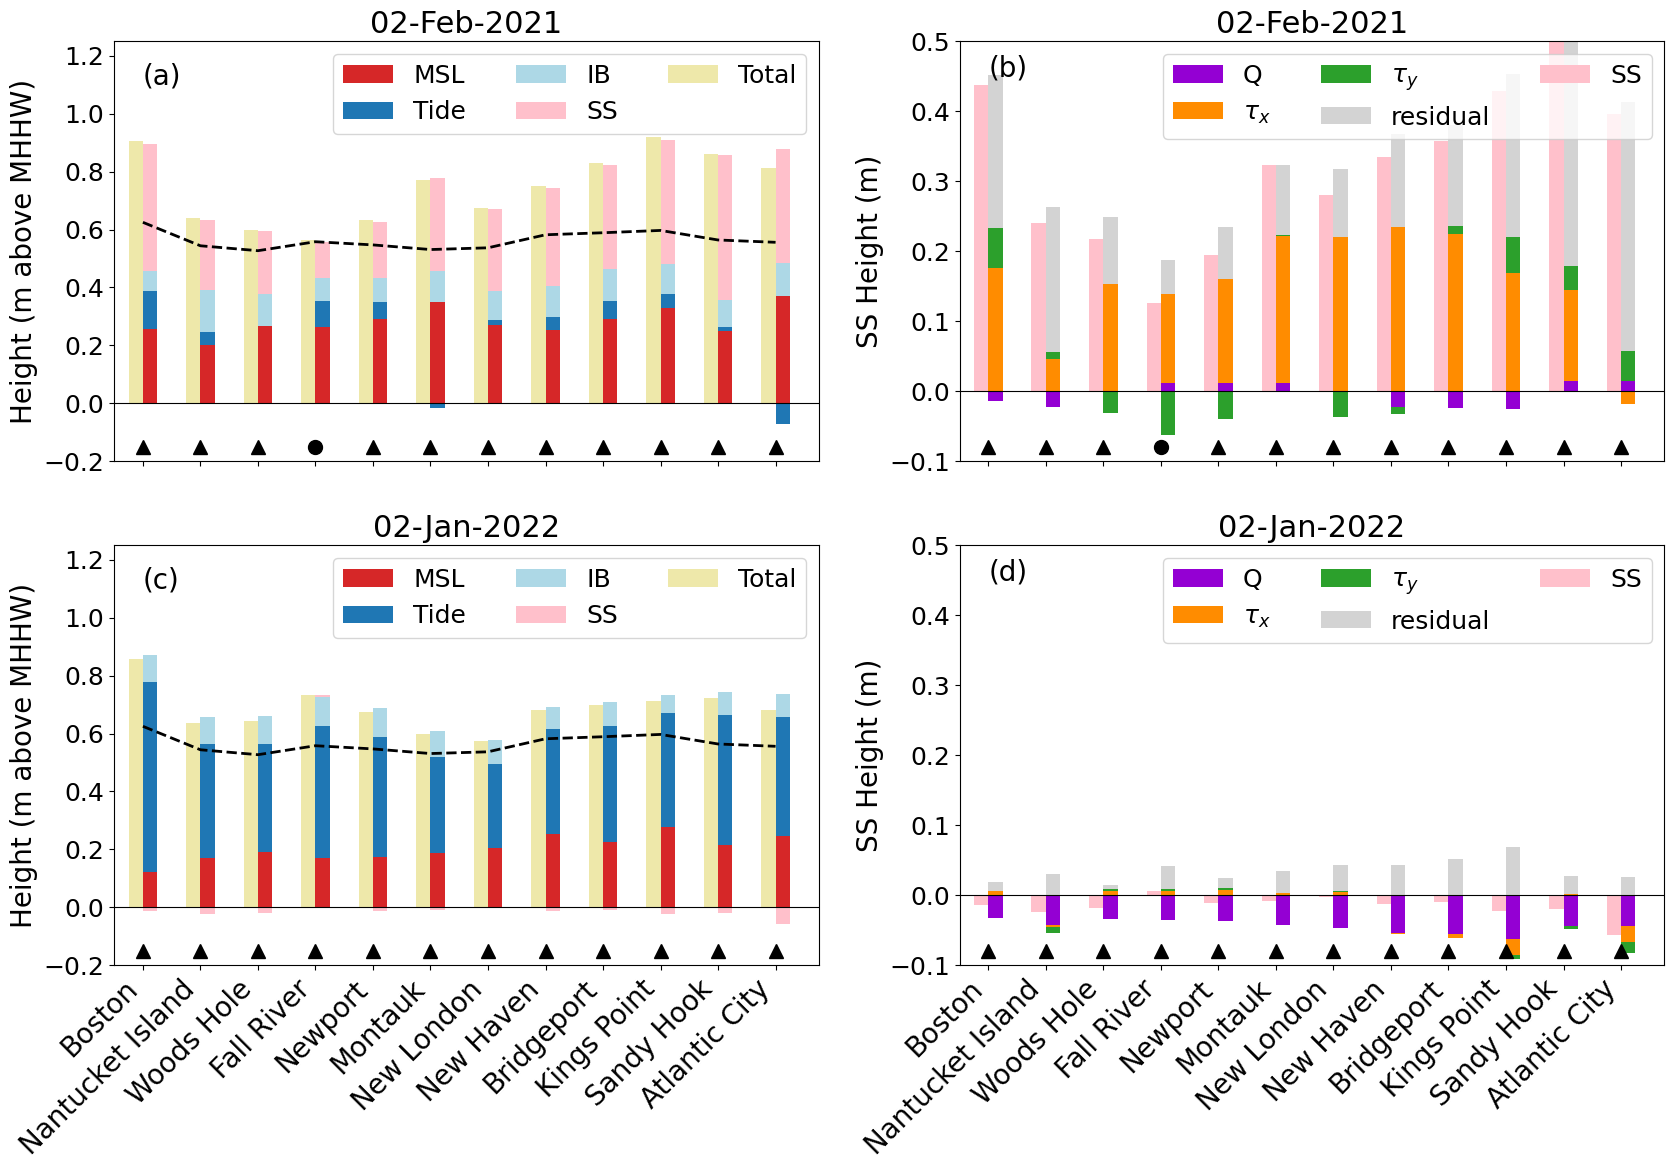

In [39]:
fig =  plt.figure(figsize=(20,12))
nrow = 2; ncol = 2
columns = [['MSL','Tide','IB','SS'],
#            ['SBJ','u','v','res']
         ['Q',r'$\tau_x$',r'$\tau_y$','residual']
          ]
w=0.25
for j,date in enumerate(plot_dates):


    rows = {}
    names = []
    refs=[]

    s = []
    for istation,station in enumerate(stations):
        da = dfs_sl[station]['df']
        if 'time' in da.columns:
            da['time']=pd.to_datetime(da['time'])
        else:
            da['time'] = pd.to_datetime(da.index)
        da.set_index('time',inplace=True)            
        da = da.resample('1D').apply(lambda x: x.loc[x['SL_tg'].idxmax()])

        # get variables we want
        TG = np.array(da['SL_tg'])
        LF=np.array(da['SL_cor']-da['SL_bp'])
        tide = np.array(da['tide'])
        IB = np.array(da['ib'])
        SS = np.array(da['SL_bp'])

        dam = pd.DataFrame({'TG':TG,
                            'MSL':LF,
                           'Tide':tide,
                            'IB':IB,
                            'SS':SS,
        #                     'SBJ':np.array(dic[station]['original']['preds']['Qy_bp'])
                           },)
        for p in  dic[station]['original']['preds'].keys():
            dam[p] = dic[station]['original']['preds'][p]
        if hilb:
            for p in ['u','v','Qy_bp']:
                dam[p] = dam[p] + dam[p+'_h']
        dam['SS'] = np.array(dic[station]['original']['Y'])
        dam['res'] = np.array(dam['SS']-dam['overall'])
        dam.rename({'Qy_bp':'SBJ','Qy_bp_h':'SBJ_h'},axis='columns',inplace=True)
        dam.set_index(days,inplace=True)   

        name = dfs_sl[stations[istation]]['dic']['name']
        names.append(name)
#         ref = dfs_sl[station]['dic']['flood_thresholds']['nos_minor']
        ref = thresholds[station]['nos_minor']
        refs.append(ref)
        nf = len(dam[dam['TG']>ref])
        dam['no_SBJ'] = np.array(dam['TG']-dam['SBJ'])

        row = dam.loc[date]
        if row['TG']> ref and row['no_SBJ']>ref:
            s.append(2)
        elif row['TG']> ref:
            s.append(1)
        elif row['no_SBJ']>ref:
            s.append(3)
        else:
            s.append(0)

        rows[station] = row
    
    # for each date:
    r = pd.DataFrame(rows).T
    r.rename({'TG':'Total'},axis='columns',inplace=True)
    r.rename({'u':r'$\tau_x$',
          'v':r'$\tau_y$',
          'SBJ':'Q',
              'res':'residual'
          
         },axis='columns',inplace=True)
    for ic, cols in enumerate(columns):
        
        ax = plt.subplot(nrow, ncol, j * ncol + ic + 1)  # Correct subplot indexing

        stacked_colors = [label_colors[col] for col in cols]
        r[cols].plot.bar(stacked=True,ax=ax,position=0,width=w,color=stacked_colors)
        label = 'Total' if ic == 0 else 'SS'
        r[[label]].plot.bar(ax=ax, alpha=1, position=1, width=w, color=label_colors[label]) # SS (SL_bp)

    
        # X positions of the bars
        x_positions = np.arange(len(s))  # Adjust if needed based on your DataFrame's index

        for i, val in enumerate(s):
            if ic==0:
                h = -0.15
                hh=1.1
            else:
                h=-0.08
                hh=0.45
            marker = 'o' if val == 1 else ('^' if val == 2 else ('*' if val == 3 else None))
            if marker:
                ax.plot(x_positions[i], h, marker, c='black',ms=10)
        
        ax.text(x_positions[0],hh,'({})'.format(letters[j * ncol + ic]),fontsize=labelsize)
        
        plt.axhline(0,color='black',linewidth=0.8)
        # Adjust x-axis limits to ensure all bars are fully visible
        xlim = ax.get_xlim()
        ax.set_xlim([xlim[0], xlim[1] + 0.5])
        plt.title(date.strftime('%d-%b-%Y'),fontsize=titlesize)
        if j==nrow-1:
            plt.xticks(np.arange(len(stations)),names,rotation=45,ha='right',fontsize=labelsize)
        else:
            plt.xticks(np.arange(len(stations)),[])
        if ic==0:
            label = 'Height (m above MHHW)'
            plt.plot(refs,linestyle='--',color='black',linewidth=2,
#                      label='flood threshold'
                    )

        else:
            label ='SS Height (m)'
        plt.legend(ncol=3,fontsize=legendsize, loc='upper right')
        plt.ylabel(label,fontsize=labelsize)
        plt.yticks(fontsize=ticksize)
        if ic==0:
            ax.set_ylim(-0.2,1.25)
        else:
            ax.set_ylim(-0.1, 0.5)
    print(date)
    print('Mean exceedance: {:.2f}'.format( np.round(np.mean(r['Total'] - refs),2)))
    print(r.mean())
    
plt.show()  


In [40]:
kurs=path_to_figures+'bars_others.png'
            
fig.savefig(kurs,format='png',dpi=300,bbox_inches='tight')

## Wind and SBJ time series

In [41]:
station = stations[1]
dam = pd.DataFrame(dic[station]['original']['preds'])
dam['SS'] = np.array(dic[station]['original']['Y'])
dam['res'] = np.array(dam['SS']-dam['overall'])
dam['TG'] = np.array(TGs[istation])
dam.rename({'Qy_bp':'SBJ'},axis='columns',inplace=True)
dam.set_index(days,inplace=True)    

df = dfs_sl[stations[istation]]['df']
name = dfs_sl[stations[istation]]['dic']['name']
names.append(name)


In [42]:
start_date = '2018-03-01'
end_date = '2018-03-08'
mar18_week = pd.date_range(start=start_date, end=end_date)
feb21_week = pd.date_range(start='2021-01-31', end='2021-02-07')
jan22_week = pd.date_range(start='2021-12-31', end='2022-01-07')


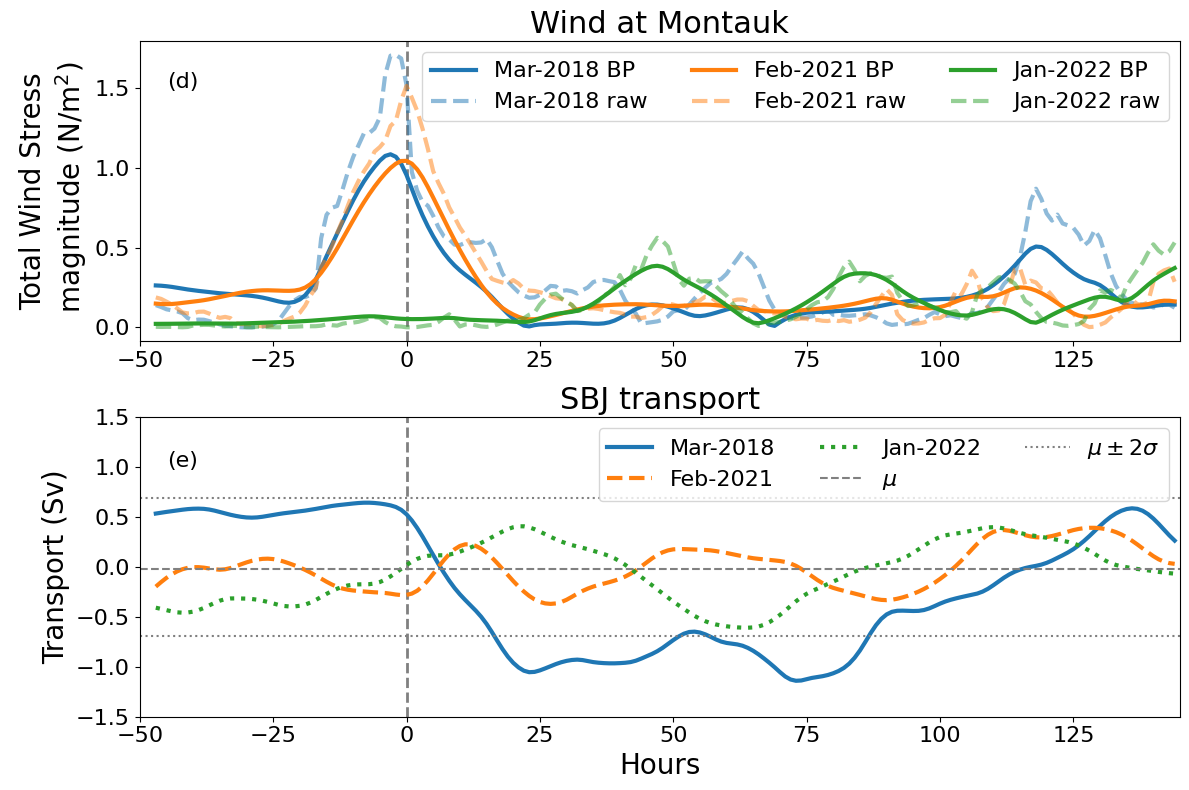

In [43]:
js = 5
station=stations[js]
da = dfs_sl[station]['df']
name = names[js]
colors=['tab:blue','tab:orange','tab:green','black']
ls = ['-','--',':','-']
dates ={'mar18':mar18_week,
       'feb21':feb21_week,
       'jan22':jan22_week,
#        'feb18':feb18_week
       }

week_labels ={'mar18':'Mar-2018',
       'feb21':'Feb-2021',
       'jan22':'Jan-2022',
#        'feb18':feb18_week
       }


fig = plt.figure(figsize=(12,8))
nrow=2;ncol=1
ax1 = plt.subplot(nrow,ncol,1)
ax2 = plt.subplot(nrow,ncol,2)

x = np.arange(1,len(mar18_week)+1)
for i,key in enumerate(dates.keys()):
    dhs = da.loc[da.index.normalize().isin(dates[key])]
#     if i==0:
#         x = dhs.index
    
    # Display the result
    # print(dhs)
    u = np.array(dhs['u_bp'])
    v = np.array(dhs['v_bp'])
    ws = np.array(np.sqrt(u**2 + v**2))
    u = np.array(dhs['u_raw'])
    v = np.array(dhs['v_raw'])
    ws2 = np.array(np.sqrt(u**2 + v**2))
    
    x = np.arange(1,len(ws)+1)
    x=x-48
    ax1.plot(x,ws,label='{} BP'.format(week_labels[key]), c= colors[i],linewidth=3,)
    ax1.plot(x,ws2,label='{} raw'.format(week_labels[key]), c= colors[i],linestyle='--',alpha=0.5,linewidth=3,)
    
    ax2.plot(x,dhs.Qy_bp,label=week_labels[key],alpha=1,c=colors[i],linewidth=3,linestyle=ls[i])

ax2.set_ylabel('\nTransport (Sv)',fontsize=labelsize)
plt.axhline(df.Qy.mean(),linestyle='--',c='gray',label='$\mu$')
plt.axhline(-2*df.Qy.std(),linestyle=':',c='gray',label='$\mu \pm 2\sigma$' )
plt.axhline(+2*df.Qy.std(),linestyle=':',c='gray')

ax1.axvline(0,linestyle='--',color='gray',linewidth=2,zorder=0)
ax2.axvline(0,linestyle='--',color='gray',linewidth=2,zorder=0)
ax2.set_title('SBJ transport',fontsize=titlesize)

ax1.set_ylabel('Total Wind Stress\n magnitude (N/m$^2$)',fontsize=labelsize)
ax1.legend(ncol=3,fontsize=ticksize-2)
ax2.legend(fontsize=ticksize-2,ncol=3,loc='upper right')
ax1.set_title('Wind at {}'.format(name),fontsize=titlesize)
# plt.yticks(fontsize=ticksize)
plt.xlabel('Hours',fontsize=labelsize)

ax2.tick_params(axis='both', labelsize=ticksize-2)
ax1.tick_params(axis='both', labelsize=ticksize-2)

ax1.set_xlim(-50,6*24+1)
ax2.set_xlim(-50,6*24+1)
# 
ax2.set_ylim(-1.5,1.5)
ax1.text(x[5], 1.5, '(d)', ha='center', fontsize=ticksize-2)
ax2.text(x[5], 1.0, '(e)', ha='center', fontsize=ticksize-2)

# ax1.set_xticks(np.arange(0,9*24,24))
# ax2.set_xticks(np.arange(0,9*24,24))

plt.tight_layout()
plt.show()



In [44]:
kurs=path_to_figures+'wind_SBJ_de.png'
            
fig.savefig(kurs,format='png',dpi=300,bbox_inches='tight')

Add SLP contours

In [45]:
import xarray as xr

In [135]:
path = '/Users/carocamargo/Documents/data/ERA5/'
file = 'hourly_slp_fullyears_2018-2022.nc'
ds = xr.open_dataset(path+file)

ds

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 26280, latitude: 121, longitude: 121)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 210kB 2018-01-01 ... 2022-12-31T2...
  * latitude    (latitude) float64 968B 50.0 49.75 49.5 ... 20.5 20.25 20.0
  * longitude   (longitude) float64 968B -90.0 -89.75 -89.5 ... -60.25 -60.0
    expver      (valid_time) <U4 420kB ...
Data variables:
    msl         (valid_time, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-18T02:04 GRIB to CDM+CF via cfgrib-0.9.1...

In [136]:
ds.valid_time

<xarray.DataArray 'valid_time' (valid_time: 26280)> Size: 210kB
array(['2018-01-01T00:00:00.000000000', '2018-01-01T01:00:00.000000000',
       '2018-01-01T02:00:00.000000000', ..., '2022-12-31T21:00:00.000000000',
       '2022-12-31T22:00:00.000000000', '2022-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 210kB 2018-01-01 ... 2022-12-31T2...
    expver      (valid_time) <U4 420kB ...
Attributes:
    long_name:      time
    standard_name:  time

In [47]:
ds = ds.rename({'valid_time': 'time'})
ds['msl'] = ds['msl'] / 100 # Convert to hPa


In [48]:
dates = {'mar18':{'day':3,
                  'month':3,
                  'year':2018,
                  'm':'Mar',
                  'lastday':31,
                  
                  },
         'feb21':{'day':2,
                'month':2,
                'year':2021,
                'm':'Feb','lastday':28,
                },
         'jan22':{'day':2,
                'month':1,
                'year':2022,
                'm':'Jan','lastday':31,
                },
       
         }

In [49]:
cmap=cmf.cm.roma_r

In [50]:
lat = float(dfs_sl[station]['dic']['lat'])
lon = float(dfs_sl[station]['dic']['lon'])


In [51]:
def cartopy_plot_tickmarks(ax,labels,axis):
    ''''
    source: https://github.com/SciTools/cartopy/issues/2003
    '''
    assert axis in ['x','y']

    ticks=[]
    values=[float(txt.get_text().split('°')[0]) for txt in labels]
    directions=[txt.get_text().split('°')[1] for txt in labels]  #what comes after the degree symbol
    for i,txt in enumerate(labels):
        value=values[i]
        if directions[i] in ['W','S']:
            ticks+=[-value]
        else:  #for 'E', 'N' and '' (e.g. 180 degrees)
            ticks+=[value]
    
    if axis=='x':
        ax.set_xticks(ticks, crs=ccrs.PlateCarree())
        ax.set_xticklabels(['' for i in range(len(ticks))])  #make new ticks have blank labels to not overplot cartopy's
    elif axis=='y':
        ax.set_yticks(ticks, crs=ccrs.PlateCarree())
        ax.set_yticklabels(['' for i in range(len(ticks))])

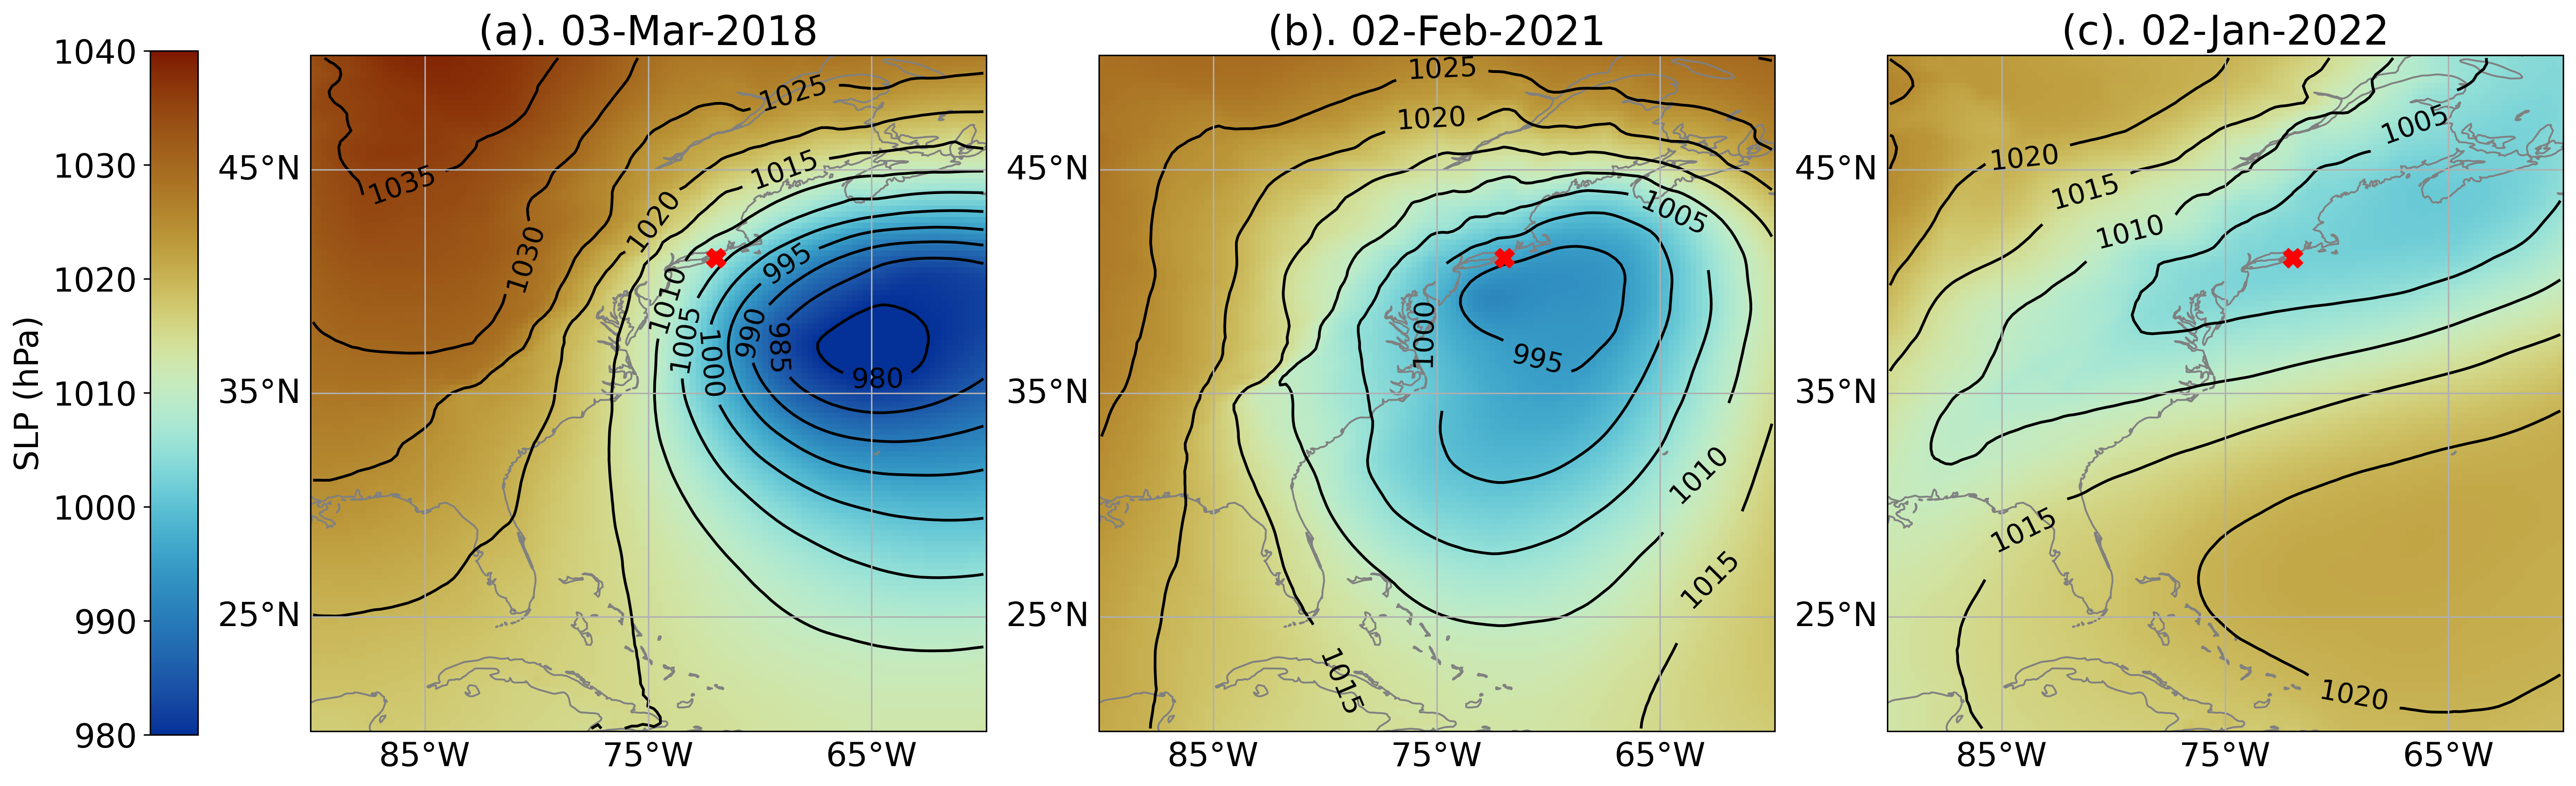

In [52]:
offset=0
# ticksize=14;legendsize=16;titlesize=18

fig, axes = plt.subplots(figsize=(18, 6), 
                         dpi=300,
                       nrows=1, ncols=3, 
                       subplot_kw={"projection": ccrs.PlateCarree()})
for i,date in enumerate(dates.keys()):
    ax = axes[i]  # Select the correct subplot axis
    month=dates[date]['month']
    m=dates[date]['m']
    year = dates[date]['year']
    day = dates[date]['day'] + offset
    lday = dates[date]['lastday']

    # (1) Compute Daily Mean 
    anomaly = ds.sel(time=slice("{}-{}-{}".format(year,month,day),
                                   "{}-{}-{}T23:59:59".format(year,month,day)
                                   )).mean(dim="time")

    # (2) Compute Monthly Mean
    # anomaly = ds.sel(time=slice("{}-{}-01".format(year,month), 
    #                                  "{}-{}-{}".format(year,month,lday))
    #                       ).mean(dim="time")

    # (3) Compute Anomaly
    # anomaly =  monthly_mean



    cs2 = ax.pcolor(anomaly.longitude, anomaly.latitude, anomaly["msl"],
                    transform=ccrs.PlateCarree(),
                    # levels=levels, 
                    cmap=cmap, 
                    vmin=980,vmax=1040,
                    # extend='both'
                    )
    # ax.clabel(cs, inline=True, fontsize=8)

    # plt.colorbar(cs2,shrink=0.85)

    # # Contour plot
    levels = np.arange(980,1040,5)  # Define contour levels
    cs = ax.contour(anomaly.longitude, anomaly.latitude, anomaly["msl"],
                    transform=ccrs.PlateCarree(),
                    levels=levels, 
                    # cmap='RdBu_r', 
                    colors='black',
                    extend='both'
                    )
    
    
    ax.scatter(lon,lat, marker='X', 
#                 edgecolor='black',
                c='red', 
                s=100, # zorder=10, 
               zorder=10,
               transform=ccrs.PlateCarree())
    ax.clabel(cs, inline=True, fontsize=15)
    
    # Add coastlines
    ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='gray')

    # Titles and labels
    ax.set_title("({}). {} {}, {}".format(letters[i],m,day,year),fontsize=titlesize)
    ax.set_title("({}). 0{}-{}-{}".format(letters[i],day,m,year),fontsize=titlesize)
    
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    
    gl = ax.gridlines(draw_labels=True,
                      ylocs=np.arange(25,56,10),
                      xlocs=np.arange(-85,-60+1,10)
                     )  # Add grid lines with labels
    gl.right_labels = False  # Disable labels on the right side
    gl.top_labels = False  # Disable labels on the top

    gl.xlabel_style = {'size': ticksize}  # Set the font size of x-axis labels
    gl.ylabel_style = {'size': ticksize}  # Set the font size of y-axis labels
#     gl.xlines = False  #removing gridlines
#     gl.ylines = False
    #getting the cartopy tick information
    plt.draw()  
    xlabels=gl.xlabel_artists
    ylabels=gl.ylabel_artists
#     cartopy_plot_tickmarks(ax,xlabels,'x')
#     if i==0:
#     cartopy_plot_tickmarks(ax,ylabels,'y')

plt.tight_layout()      
# cbar_ax = fig.add_axes([1, 0.025, 0.02, 0.945])  # [left, bottom, width, height]
cbar_ax = fig.add_axes([-0.02, 0.07, 0.02, 0.86])  # [left, bottom, width, height]

cbar = fig.colorbar(cs2, cax=cbar_ax)
cbar.set_label("SLP (hPa)", fontsize=legendsize)

# Move colorbar title (label) to the left
cbar.ax.yaxis.set_label_position("left")

# Move colorbar ticks to the left
cbar.ax.yaxis.set_ticks_position("left")

# Adjust tick label size
cbar.ax.tick_params(labelsize=ticksize)

# plt.suptitle('Daily average')

# Show plot
#
# plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar

plt.show()

In [53]:
kurs=path_to_figures+'slp_left.png'
            
fig.savefig(kurs,format='png',dpi=300,bbox_inches='tight')

Above figures are combined on PPT. 

# Waves

In [58]:
path_save = '/Users/carocamargo/Documents/data/floodSBJ/'
filename = 'waves'
dicw = open_dict(path_save,filename,)
print(dicw.keys())

buoys = [key for key in dicw.keys()]
buoys.remove('44085') # buzzards bay which starts only in 2022

buoynames = []
for ib, buoy in enumerate(buoys):
    buoynames.append(dicw[buoy]['meta']['long_name'])
    

dict_keys(['44013', '44090', '44020', '44085', '44011', '44097', '44017', '44008', '44065', '44025', '44091', '44066', '44009'])


In [59]:
from scipy.stats import pearsonr, spearmanr, kendalltau

In [60]:
from scipy import stats
rng = np.random.default_rng()
mtd = stats.BootstrapMethod(method='BCa')


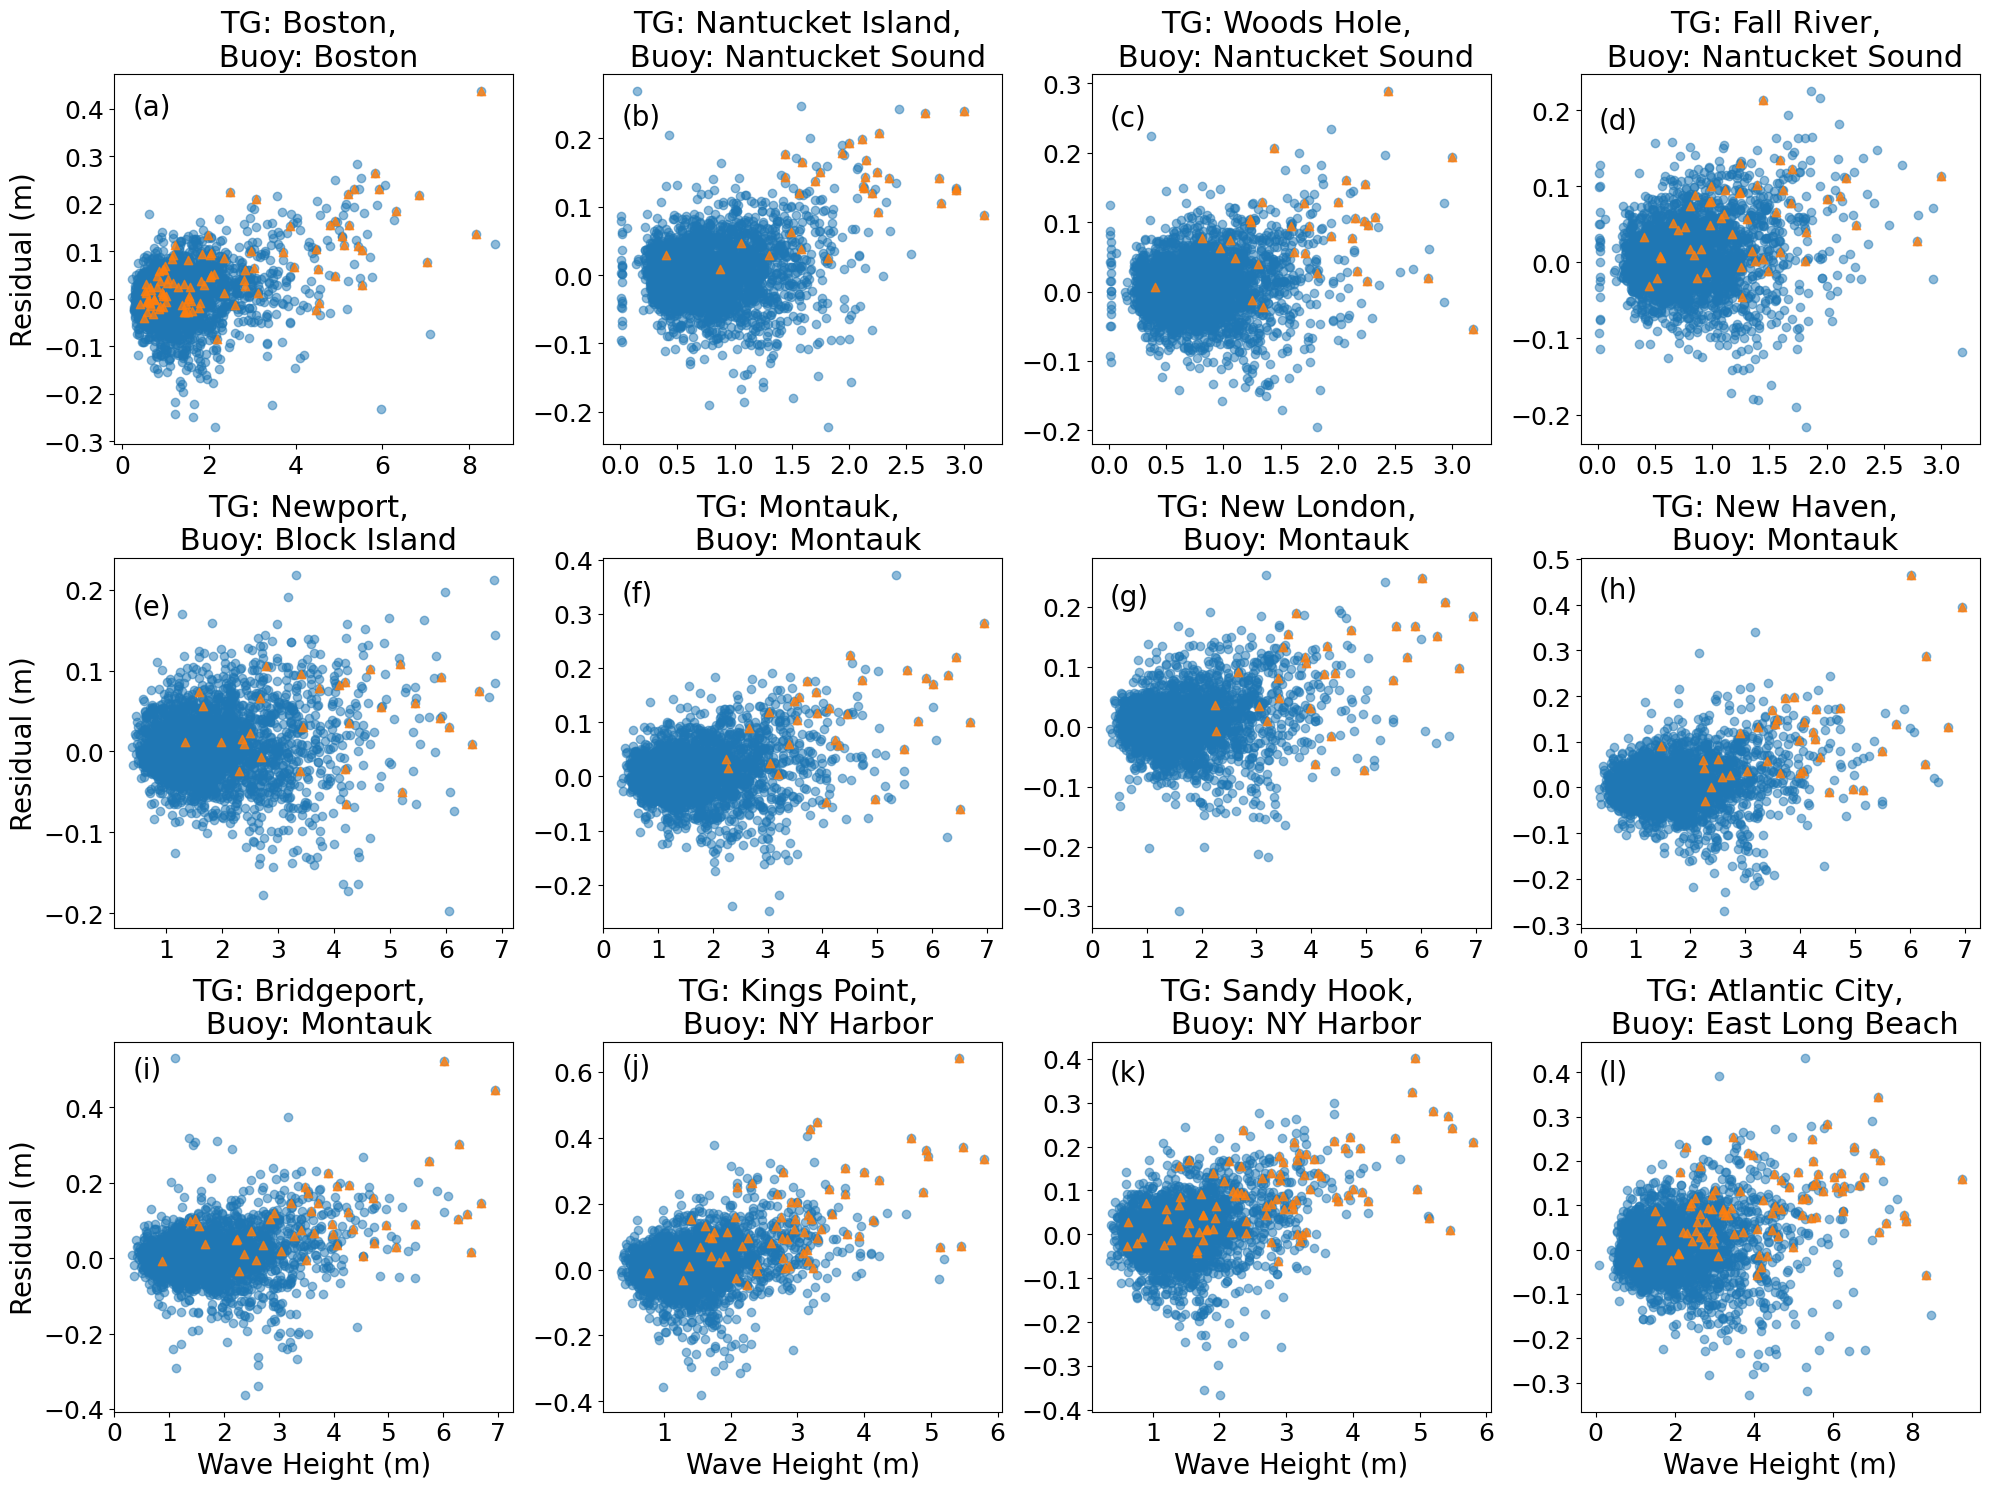

In [88]:
fig = plt.figure(figsize=(20,15))


buoy_idx = [0,2,2,2,4,5,5,5,
#             7,
            5, # change buoy of Brigeport to Montauk
            7,7,
#             9 # change buoy of  Atlantic City to East long Beach
            10
           ]
tg_idx = np.arange(0,len(stations))
# buoy = buoys[ib]
# station = stations[js]

nrow=3;ncol=4
c_alldays =[]
c_flood =[]
p_alldays =[]
p_flood =[]
n_flood = []
name_buoys = []
name_tg = []
ci_l_all = []
ci_u_all = []
ci_l_flood = []
ci_u_flood = []

# fig = plt.figure()
for ib,js in zip(buoy_idx,tg_idx):

    station = stations[js]
    buoy = buoys[ib]
    damo = pd.DataFrame(dic[station]['original']['preds'])
    if hilb:
        for p in ['u','v','Qy_bp']:
            damo[p] = damo[p] + damo[p+'_h']
    damo['SS'] = np.array(dic[station]['original']['Y'])
    # compute residual
    damo['res'] = np.array(damo['SS']-damo['overall'])
    # rename columns
    damo.rename({'Qy_bp':'SBJ','Qy_bp_h':'SBJ_h'},axis='columns',inplace=True)
    damo.set_index(dd.index,inplace=True)   
    
#     print('\n TG: {}'.format(names[js]))
    name_tg.append(names[js])
#     print('Buoy: {}'.format(buoynames[ib]))
    name_buoys.append(buoynames[ib])
    
    dw = dicw[buoy]['df'].copy() 
    dw = dw[['WVHT']]
#     dw['WDIR'] = np.array(dw['WDIR']).astype(float)
    # transform in daily
    dw = dw.resample('1D').max()
    
    # join with SS data 
    dw = damo.join(dw,on='time')
    dw = dw.dropna()
#     flood_days = dfs_sl[station]['flood_days'].index
    df = dfs_sl[station]['df']
    df = df.resample('1D').apply(lambda x: x.loc[x['SL_tg'].idxmax()])
    ref = thresholds[station]['nos_minor']
    flood_days = df[df['SL_tg'] > ref].index
#     flood_days = out[station]['original']['flood_days']
    flood_days = flood_days[flood_days.isin(dw.index)]
    n_flood.append(len(flood_days))
    df = dw.loc[flood_days]


    
    ax = plt.subplot(nrow,ncol,int(js+1))
    
    # all days
    res = pearsonr(dw['res'],dw['WVHT'])
    c,p = res
    ci = res.confidence_interval(confidence_level=0.9,method=mtd)
    
    plt.scatter(dw['WVHT'],dw['res'], 
                alpha=0.5,
                label ='All days \n c= {:.2f}'.format( c))
    p_alldays.append(p)
    c_alldays.append(c)
    ci_l_all.append(ci[0])
    ci_u_all.append(ci[1])
    
    # flood days
    res = pearsonr(df['res'],df['WVHT'],)
    c,p = res
    ci = res.confidence_interval(confidence_level=0.9, method=mtd)

    plt.scatter(df['WVHT'], df['res'],
                alpha=0.8,
                marker='^',
                label ='Flood days (n= {}) \n c= {:.2f} '.format(len(df), c))
    p_flood.append(p)
    c_flood.append(c)
    ci_l_flood.append(ci[0])
    ci_u_flood.append(ci[1])
    ax.text(min(df['WVHT'].min(),dw['WVHT'].min()),
        max(df['res'].max(),dw['res'].max())-0.05, ### NOT ALLIGNED!!!
        '({})'.format(letters[js]),
       fontsize=labelsize)
    

    plt.ylabel('Residual (m)')
    plt.xlabel('Wave Height (m)')
    
#     title = 'TG: {}, \n Buoy: {}\nFlood days (n= {}) \n c= {:.2f}'.format(
#         names[js],buoynames[ib],len(df),c
#                                           )

    title = 'TG: {}, \n Buoy: {}'.format(names[js],buoynames[ib],)
    plt.title(title,
              fontsize=titlesize)
#     plt.legend(fontsize=ticksize)
    if js%4==0:        
        plt.ylabel('Residual (m)',fontsize=labelsize)
    else:
        plt.ylabel('')

    if js>7:
        plt.xlabel('Wave Height (m)',fontsize=labelsize)
    else:
        plt.xlabel('')
    plt.yticks(fontsize=ticksize)
    plt.xticks(fontsize=ticksize)

plt.tight_layout()
plt.show()

    

In [89]:
kurs=path_to_figures+'wave_scatter_all.png'
            
fig.savefig(kurs,format='png',dpi=300,bbox_inches='tight')



 TG: Boston
Buoy: Boston

 TG: Woods Hole
Buoy: Nantucket Sound


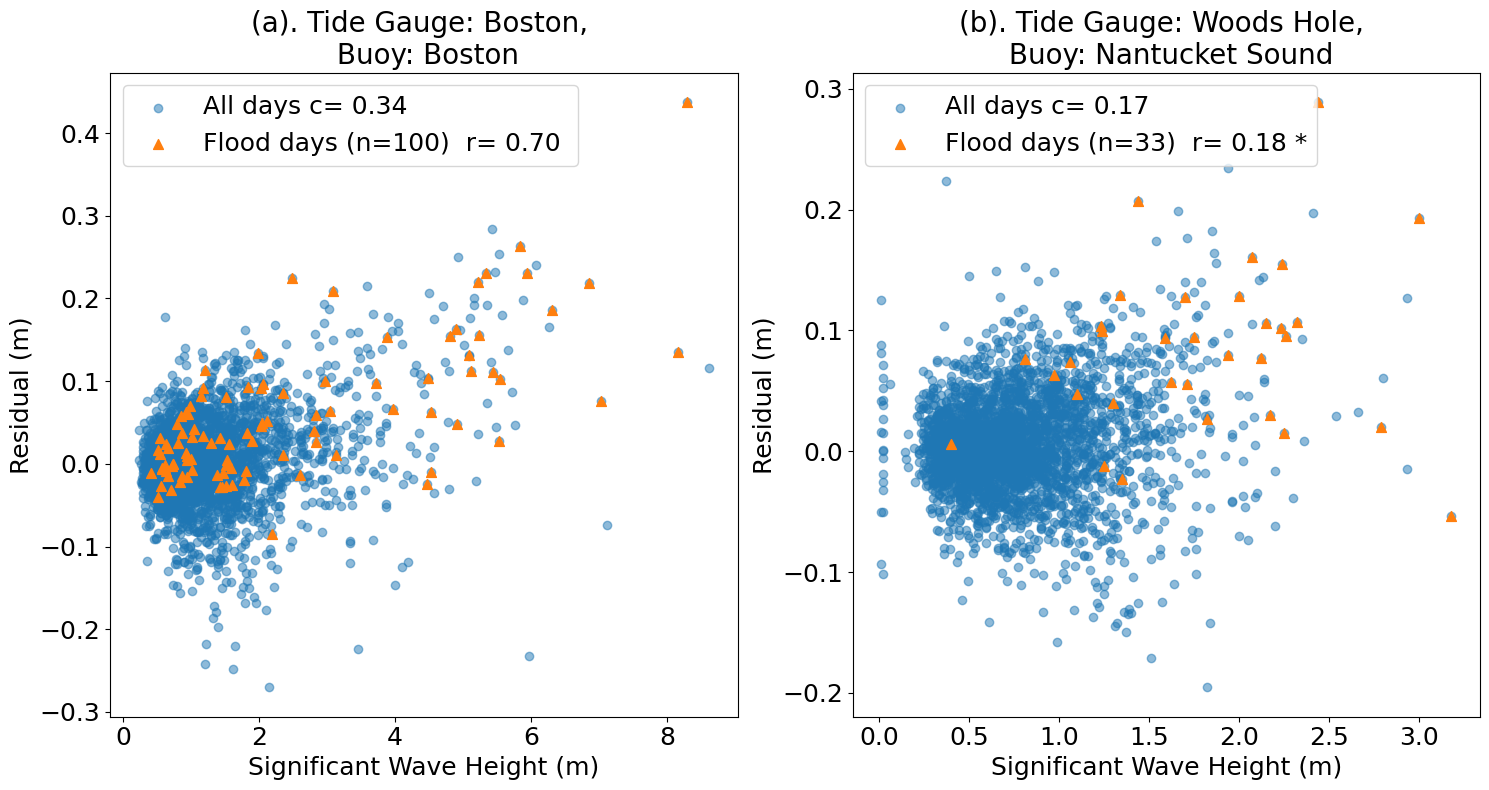

In [90]:
# plt.figure(figsize=(25,15))


buoy_idx = [0,2,2,2,4,5,5,5,
#             7,
            5, # change buoy of Brigeport to Montauk
            7,7,
#             9 # change buoy to Atlantic City to East long Beach
            10
           ]
tg_idx = np.arange(0,len(stations))
buoy = buoys[ib]
station = stations[js]

nrow=3;ncol=4
# for ib,js in zip(buoy_idx,tg_idx):

nrow=1;ncol=2
buoy_idx = [0,2]
tg_idx=[0,2]
i=0
fig = plt.figure(# dpi=300,
                 figsize=(15,8))

ypos = [0.33,0.25];xpos = [7,3]
for ib,js in zip(buoy_idx,tg_idx):
    
    
    station = stations[js]
    buoy = buoys[ib]
    damo = pd.DataFrame(dic[station]['original']['preds'])
    if hilb:
        for p in ['u','v','Qy_bp']:
            damo[p] = damo[p] + damo[p+'_h']
    damo['SS'] = np.array(dic[station]['original']['Y'])
    # compute residual
    damo['res'] = np.array(damo['SS']-damo['overall'])
    # rename columns
    damo.rename({'Qy_bp':'SBJ','Qy_bp_h':'SBJ_h'},axis='columns',inplace=True)
    damo.set_index(dd.index,inplace=True)   
    
    print('\n TG: {}'.format(names[js]))
    print('Buoy: {}'.format(buoynames[ib]))
    
    dw = dicw[buoy]['df'].copy() 
    dw = dw[['WVHT']]
#     dw['WDIR'] = np.array(dw['WDIR']).astype(float)
    # transform in daily
    dw = dw.resample('1D').max()
    
    # join with SS data 
    dw = damo.join(dw,on='time')
    dw = dw.dropna()
    df = dfs_sl[station]['df']
    df = df.resample('1D').apply(lambda x: x.loc[x['SL_tg'].idxmax()])
    ref = thresholds[station]['nos_minor']
    flood_days = df[df['SL_tg'] > ref].index
    
#     flood_days = dfs_sl[station]['flood_days'].index
#     flood_days = out[station]['original']['flood_days']
    flood_days = flood_days[flood_days.isin(dw.index)]
    df = dw.loc[flood_days]


    
    ax = plt.subplot(nrow,ncol,int(i+1))

#     ax = plt.subplot(111)
    c,p = pearsonr(dw['res'],dw['WVHT'],)
    
    label ='All days r= {:.2f} '.format(c)
    if p>0.05:
        label = label+'*'
    plt.scatter(dw['WVHT'],dw['res'], 
                alpha=0.5,
                label ='All days c= {:.2f} '.format( c, ))
    
    c,p = pearsonr(df['res'],df['WVHT'],)

    label ='Flood days (n={})  r= {:.2f} '.format(len(df), c)
    if p>0.05:
        label = label+'*'
    plt.scatter(df['WVHT'], df['res'],
                alpha=1,
                marker='^',
                s=50,
                label =label)

    
    
    plt.ylabel('Residual (m)',fontsize=labelsize-2)
    plt.xlabel('Significant Wave Height (m)',fontsize=labelsize-2)
    plt.yticks(fontsize=ticksize)
    plt.xticks(fontsize=ticksize)


    title = '({}). Tide Gauge: {}, \n Buoy: {}'.format(letters[i],names[js],buoynames[ib],)
    plt.title(title,
              fontsize=labelsize)
    plt.legend(fontsize=ticksize,
#                bbox_to_anchor=(1.05, 1)
               loc='upper left'
              )
#     ax.text(xpos[i],ypos[i],
        
#         '({})'.format(letters[i]),
#        fontsize=labelsize)
    i=i+1

plt.tight_layout()
plt.show()
    


In [91]:
kurs=path_to_figures+'wave_scatter_sel.png'
            
fig.savefig(kurs,format='png',dpi=300,bbox_inches='tight')

### Stations map

In [92]:
lat = [dicw[station]['meta']['lat'] for station in buoys]
lon = [dicw[station]['meta']['lon'] for station in buoys]
buoynames = [dicw[station]['meta']['long_name'] for station in buoys]

cat = pd.DataFrame({'lat':lat,
                  'lon':lon},
                 index = buoynames)


In [93]:

# Convert station names to numerical categories
cat["color_id"] = pd.Categorical(cat.index).codes

# stations = [key for key in dfs_sl.keys()]
lats = [float(dfs_sl[station]['dic']['lat']) for station in stations]
lons = [float(dfs_sl[station]['dic']['lon']) for station in stations]
names = [dfs_sl[station]['dic']['name'] for station in stations]
colors_tg_idx = pd.Categorical(names).codes

In [94]:
cats = cat.loc[['Boston',
         'Nantucket Sound',
         'Block Island',
         
         'Montauk',
         'NY Harbor',
         'East Long Beach'
        ]]

In [95]:
buoy_idx = [0,2,2,2,4,5,5,5,
#             7,
            5, # change buoy of Brigeport to Montauk
            7,7,
#             9 # change buoy to Atlantic City to East long Beach
            10
           ]


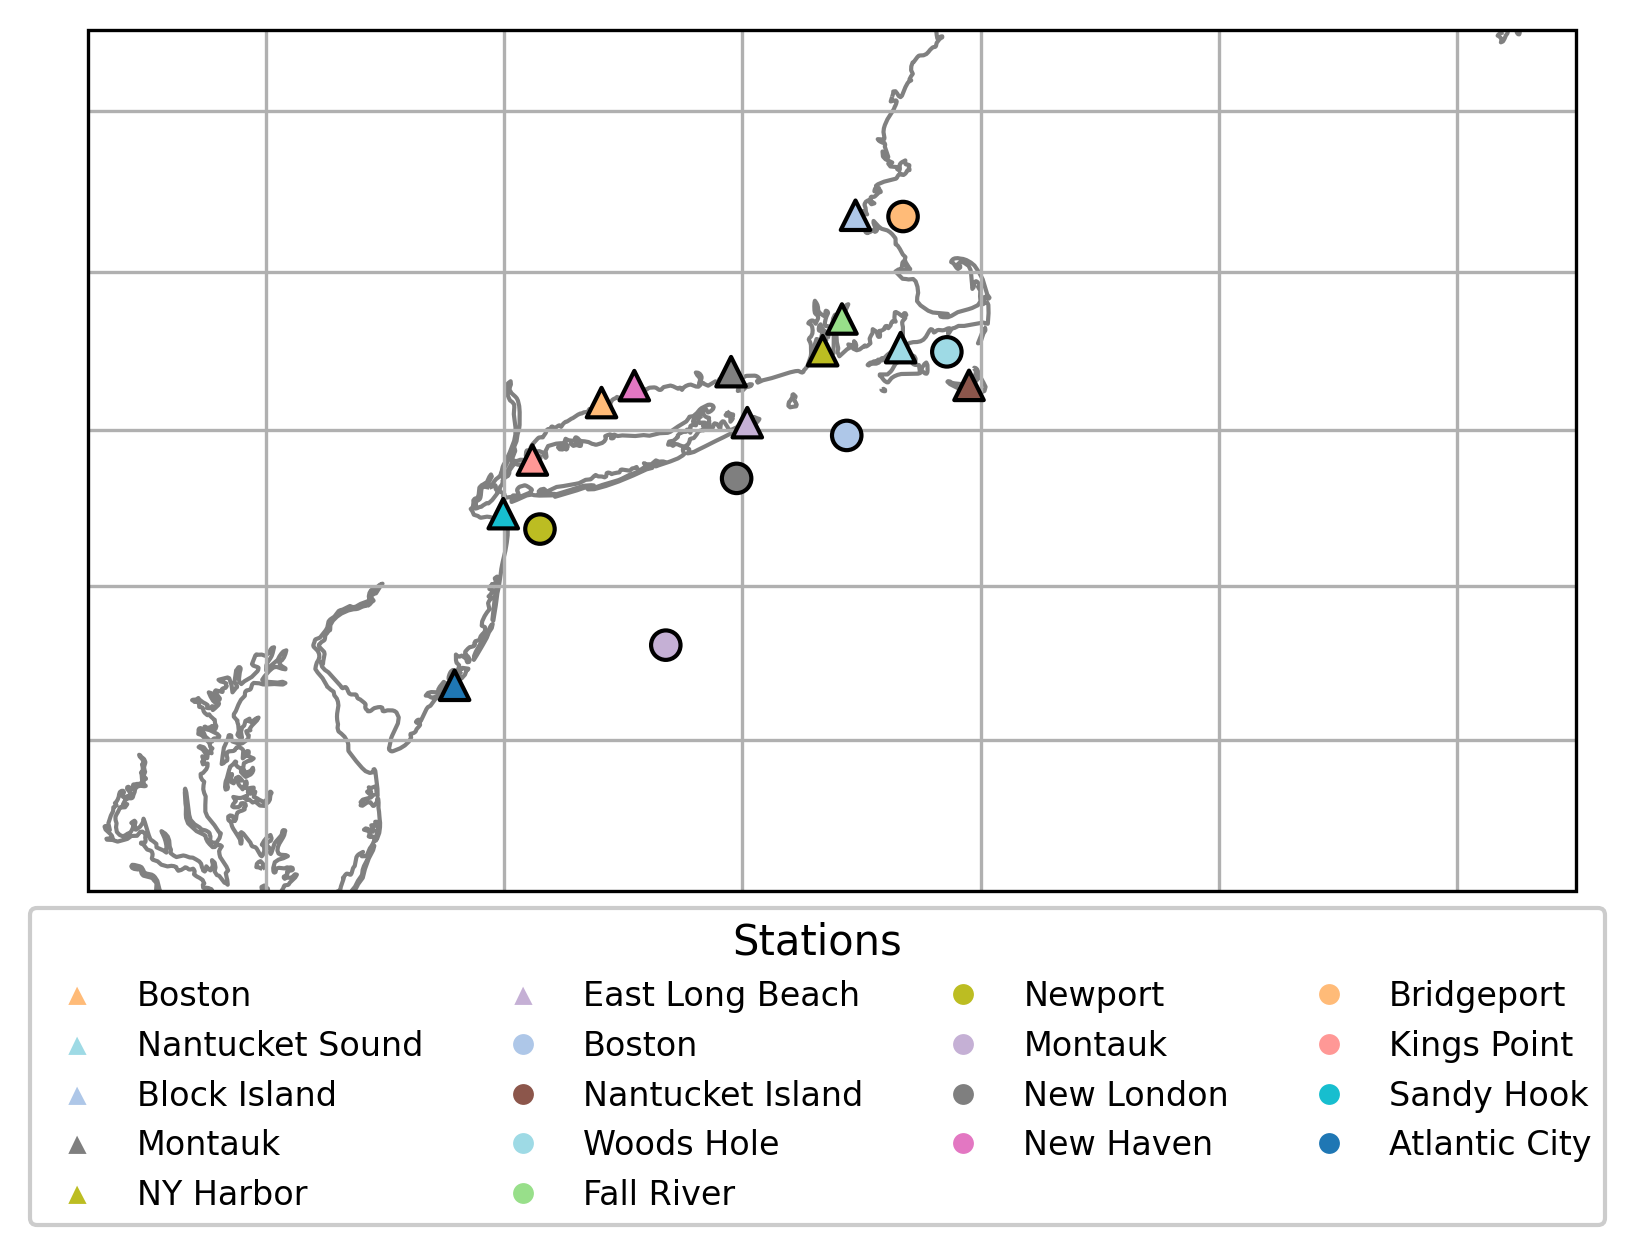

In [96]:
cmap = plt.get_cmap('tab20')  # Use a categorical colormap
colors = cmap(cats["color_id"] / cats["color_id"].max())  # Normalize color indices
colorstg = cmap(colors_tg_idx/ max(colors_tg_idx))  # Normalize color indices

fig, ax = plt.subplots(dpi=300, subplot_kw={'projection': ccrs.Mercator()})

# Scatter plot with unique colors for each station
sc = ax.scatter(cats['lon'], cats['lat'], marker='o', 
                edgecolor='black',
                c=colors, s=50, zorder=10, transform=ccrs.PlateCarree())

sc = ax.scatter(lons,lats, marker='^', 
                edgecolor='black',
                c=colorstg, 
                s=50, zorder=10, transform=ccrs.PlateCarree())


ax.coastlines(color='gray')
ax.gridlines()
# plt.title('Wave Buoy  and Tide Gauge Stations')

# Create legend handles
legend_handles = [plt.Line2D([0], [0], marker='^', color='w', 
                             markerfacecolor=colors[i], markersize=6, label=station) 
                  for i, station in enumerate(cats.index)]

legend_handles2 = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=colorstg[i], markersize=6, label=station) 
                   for i, station in enumerate(names)]

ax.legend(handles=legend_handles + legend_handles2, 
          loc='upper left', 
          bbox_to_anchor=(-0.05, 0),  # Moves the legend outside the plot
          title="Stations", 
          fontsize=8, 
          ncol=4, 
          framealpha=1)


# Set map extent
ax.set_extent([-77.5, -65, 38, 43.5], crs=ccrs.PlateCarree())

plt.show()

In [97]:
kurs=path_to_figures+'study_region.png'
            
fig.savefig(kurs,format='png',dpi=300,bbox_inches='tight')

# Compare R2 scores

In [103]:
path = '/Users/carocamargo/Documents/data/floodSBJ/'

filenames = ['SBJ_SS_regressions_ridge_1000_norm',
                'SBJ_SS_regressions_ridge_1000_norm_hilb',
                'SBJ_SS_regressions_ridge_1000_minorflood_norm',
             'SBJ_SS_regressions_linear_1000_norm',
                ]
params = ['overall','Qy_bp','u_bp','v_bp']

coefs = np.zeros((len(params),len(filenames),len(stations)))
coefs_f = np.zeros((len(params),len(filenames),len(stations)))
ci_l = np.full_like(coefs,0)
ci_u = np.full_like(coefs,0)
ci_l_f = np.full_like(coefs,0)
ci_u_f = np.full_like(coefs,0)

for i,filename in enumerate(filenames):
    dic = open_dict(path,filename,)
    for j, param in enumerate(params):
        # get all stations and then take mean!!! ############HERE$############
        coefs[j,i,:] = [np.array(dic[station]['original']['r2s'][param]) * 100 for station in stations]
        ci_l[j,i,:] = [np.array(dic[station]['bootstrap']['stats_r2']['cis'][j][0]) * 100 for station in stations]
        ci_u[j,i,:] = [np.array(dic[station]['bootstrap']['stats_r2']['cis'][j][1]) * 100 for station in stations]
        
        coefs_f[j,i,:] = [np.array(dic[station]['original']['r2s_floods'][param]) * 100 for station in stations]
        ci_l_f[j,i,:] = [np.array(dic[station]['bootstrap']['stats_r2_flood']['cis'][j][0]) * 100 for station in stations]
        ci_u_f[j,i,:] = [np.array(dic[station]['bootstrap']['stats_r2_flood']['cis'][j][1]) * 100 for station in stations]
        
    if 'hilb' in filename:
        if param != 'overall':
            paramh = param+'_h'
#             coefs[j,i] = coefs[j,i] +  np.array(dic[station]['original']['r2s'][paramh] * 100)
            coefs[j,i,:] = [np.array(dic[station]['original']['r2s'][paramh]) * 100 + coefs[j,i,k] 
                            for k,station in enumerate(stations)]
            ci_l[j,i,:] = [np.array(dic[station]['bootstrap']['stats_r2']['cis'][j][0]) * 100 + ci_l[j,i,k]
                           for k,station in enumerate(stations)]
            ci_u[j,i,:] = [np.array(dic[station]['bootstrap']['stats_r2']['cis'][j][1]) * 100 + ci_u[j,i,k]
                           for k,station in enumerate(stations)]
        
    
            coefs_f[j,i,:] = [np.array(dic[station]['original']['r2s_floods'][paramh]) * 100 + coefs_f[j,i,k] 
                            for k,station in enumerate(stations)]
            ci_l_f[j,i,:] = [np.array(dic[station]['bootstrap']['stats_r2_flood']['cis'][j][0]) * 100 + ci_l_f[j,i,k]
                           for k,station in enumerate(stations)]
            ci_u_f[j,i,:] = [np.array(dic[station]['bootstrap']['stats_r2_flood']['cis'][j][1]) * 100 + ci_u_f[j,i,k]
                           for k,station in enumerate(stations)]


In [104]:
a = np.vstack([coefs, # ci_l, ci_u, 
               coefs_f, # ci_l_f, ci_u_f
              ])
a = a.mean(axis=2)

In [105]:
table = pd.DataFrame(np.round(a,0),columns = ['without Hilb','With Hilb',
                                              'Only minor (nH)','OLS (nH)'
                                             ],index = params*2)
table

without Hilb  With Hilb  Only minor (nH)  OLS (nH)
overall          62.0       68.0             62.0      65.0
Qy_bp            29.0       27.0             29.0      31.0
u_bp             38.0       38.0             38.0      42.0
v_bp              3.0        5.0              3.0       3.0
overall          66.0       73.0             64.0      64.0
Qy_bp            25.0       24.0             28.0      24.0
u_bp             30.0       30.0             26.0      26.0
v_bp              5.0        8.0              3.0       1.0

nH indicates "no Hilbert"; 

In [106]:
# low CI
a = np.vstack([ci_l, # ci_u, 
               ci_l_f, # ci_u_f
              ])
a = a.mean(axis=2)
table = pd.DataFrame(np.round(a,0),columns = ['without Hilb','With Hilb',
                                              'Only minor (nH)','OLS (nH)'
                                             ],index = params*2)
table

without Hilb  With Hilb  Only minor (nH)  OLS (nH)
overall          59.0       65.0             59.0      62.0
Qy_bp            26.0       24.0             26.0      28.0
u_bp             35.0       35.0             35.0      38.0
v_bp              2.0        3.0              2.0       1.0
overall          48.0       58.0             42.0      38.0
Qy_bp             4.0        5.0              5.0      -3.0
u_bp              2.0        1.0             -5.0     -11.0
v_bp             -8.0      -14.0            -10.0     -18.0

In [107]:
# high CI

a = np.vstack([ci_u, # ci_u, 
               ci_u_f, # ci_u_f
              ])
a = a.mean(axis=2)
table = pd.DataFrame(np.round(a,0),columns = ['without Hilb','With Hilb',
                                              'Only minor (nH)','OLS (nH)'
                                             ],index = params*2)
table

without Hilb  With Hilb  Only minor (nH)  OLS (nH)
overall          65.0       70.0             65.0      68.0
Qy_bp            32.0       30.0             32.0      35.0
u_bp             42.0       42.0             42.0      46.0
v_bp              5.0        9.0              5.0       5.0
overall          79.0       83.0             78.0      79.0
Qy_bp            43.0       41.0             47.0      45.0
u_bp             52.0       53.0             50.0      52.0
v_bp             15.0       29.0             15.0      16.0

# Wind Comparison

See also compare_wind.py script

In [108]:
def open_wind_csv(file):
    df = pd.read_csv(file,header= 8,
                     low_memory=False,
    #                  dtype={
    #     ' Speed': 'float',
    #     ' Direction': 'float',
    #     # ' Gust': 'float',
    #     # ' Direction.1': 'float'  # if needed
    # },
    na_values=[' ', '', 'NaN', 'nan', 'Error']  # mark problematic entries as NaN

                     
                     )
    df = df.drop([' X',' R '],axis=1)
    df = df.rename(columns={'Date Time':'date', 
                            ' Speed':'Speed', 
                            ' Direction':'Angle', 
                            ' Direction.1':'Direction', 
                            ' Gust':'Gust',}) 
    # df = df.drop(df[df['date']==].index)
    error_msg = ['Error: No data was found. This product may not be offered at this station at the requested time.',
        'Error: No data was found. This product may not be offered at this station at the requested time. No data was found. This product may not be offered at this station at the requested time. No data was found. This product may not be offered at this station at the requested time. No data was found. This product may not be offered at this station at the requested time. No data was found. This product may not be offered at this station at the requested time. No data was found. This product may not be offered at this station at the requested time. No data was found. This product may not be offered at this station at the requested time. No data was found. This product may not be offered at this station at the requested time. No data was found. This product may not be offered at this station at the requested time. No data was found. This product may not be offered at this station at the requested time. No data was found. This product may not be offered at this station at the requested time.1-01 01:00',
        ' No data was found. This product may not be offered at this station at the requested time. No data was found. This product may not be offered at this station at the requested time.1-01 00:00',
        ]
    for error in error_msg:
        df = df.drop(df[df['date']==error].index)

    # df['date']=correct_time_atm(df)
    # df = df.reset_index(drop=True)
    
    # Clean and convert columns to numeric
    df['Speed'] = pd.to_numeric(df['Speed'], errors='coerce')
    df['Gust'] = pd.to_numeric(df['Gust'], errors='coerce')
    df['Angle'] = pd.to_numeric(df['Angle'], errors='coerce')
    # df['Direction'] = pd.to_numeric(df['Direction'], errors='coerce')

    # Drop rows with any NaNs
    df = df.dropna()
    df = df.reset_index(drop=True)
    
    return df

def noaaMetadata(station_id,info=False):
    ''' 
    Inputs station id, returns dictionary with metadata (ID, name, lat, lon)
    
    # Example usage
    station_id = "9414290"  # Station ID for San Francisco, CA
    noaaMetadata(station_id)

    '''
    
    import requests
    base_url = "https://tidesandcurrents.noaa.gov/api/datagetter"
    payload = {
        "product": "hourly_height",
        "application": "NOS.COOPS.TAC.WL",
        "begin_date": "20220101",
        "end_date": "20220102",
        "station": station_id,
        "datum": "MSL",
        "units": "metric",
        "time_zone": "GMT",  # Local Standard Time/Local Daylight Time
        "format": "json",
    }
    
    response = requests.get(base_url, params=payload)
    data = response.json()

    if "error" in data:
        print("Error:", data["error"]["message"])
    else:
        # Extract metadata
        metadata = data["metadata"]
        
        if info:
            # Print station metadata
            print("Station ID:", metadata["id"])
            print("Name:", metadata["name"])
            print("Latitude:", metadata["lat"])
            print("Longitude:", metadata["lon"])
        
        return metadata
    
def cut_ds(ds,bbox,lon_name='lon',lat_name='lat'):
    lon_min,lon_max,lat_min,lat_max = bbox
    mask = (
        (ds[lon_name] <= lon_max)
        & (ds[lon_name] >= lon_min)
        & (ds[lat_name] <= lat_max)
        & (ds[lat_name] >= lat_min)
    ).compute()
    return ds.where(mask, drop=True)

def find_closest_cell(ds, lat1, lon1,remove_nan=False,mask=True):
    """
    Find the index of the closest latitude and longitude to the given coordinates.
    
    Parameters:
    ds (xarray.Dataset): The dataset containing 'latitude' and 'longitude' coordinates.
    lat1 (float): The latitude of the target point.
    lon1 (float): The longitude of the target point.
    
    Returns:
    tuple: The index of the closest latitude and longitude.
    """
    
    if remove_nan:
        # Drop latitudes and longitudes where u and v are NaN across all time steps
        # ds = ds.dropna(dim='latitude', how='all', subset=['u', 'v'])
        # ds = ds.dropna(dim='longitude', how='all', subset=['u', 'v'])
        # this is not working, so we can create a mask instead
        if mask:
            mask = np.array(dm.mask)
            # mask[np.isfinite(mask)]=np.nan
        elif 'time' in dm.coords:
            mask = np.array(dm['u'].mean(dim='time')*dm['v'].mean(dim='time'))
            
        else:
            mask = np.array(dm['u']*dm['v'])
        mask[np.isfinite(mask)]=1
        

    # Extract latitude and longitude from the dataset
    lats = ds['latitude'].values
    lons = ds['longitude'].values

    # Convert latitude and longitude to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lats_rad = np.radians(lats[:, np.newaxis])
    lons_rad = np.radians(lons)

    # Haversine formula to calculate distance between two lat/lon points
    dlat = lats_rad - lat1_rad
    dlon = lons_rad - lon1_rad
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lats_rad) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    R = 6371  # Earth radius in kilometers
    distances = R * c
    
    if remove_nan:
        distances[np.isnan(mask)] = 999999
    # Find the index of the minimum distance
    min_dist_idx = np.unravel_index(np.argmin(distances), distances.shape)
    
    return min_dist_idx

In [109]:
#%% open tg wind 
path = '/Users/carocamargo/Documents/data/wind/'
start_year=2013
end_year=2024
datum='MSL'
product='wind'
station_id =  8461490 #New London, wind only until 2020
station_id = 8452660 # Newport, RI - 	Sep 23, 1991
filename = path+"wind/{}_{}_{}_{}_{}.csv".format(product,
    station_id,start_year,end_year,datum)
df = open_wind_csv(filename)
meta = noaaMetadata(station_id)
tg_lon = float(meta['lon'])
tg_lat = float(meta['lat'])


#%% get hourly mean of df
df['date']=pd.to_datetime(df['date'])
df.set_index('date',inplace=True)

df = df[['Speed']]
df.rename({'Speed':'tg_W'},axis=1,inplace=True)
df = df.resample('h').mean(numeric_only=True) # this will drop the direction (which we cant take the mean)
#%% OOI central location
#     # Central Mooring Location: 40.1000, -70.8800
ooip_lon =-70.8
ooip_lat = 40.1

#%% open ERA 5 
path = '/Users/carocamargo/Documents/data/ERA5/'
file = 'wind_single_2013-2024.nc'

# file = 'wind_single_2013-2024.nc'

dm = xr.open_dataset(path+file)

file='mask.nc'
ds = xr.open_dataset(path+file)

# grid boxes where this parameter has a value above 0.5 can only be comprised of land 
# and those grid boxes with a value of 0.5 and below can only be comprised of ocean. 
mask = np.array(ds['lsm'].isel(valid_time=0))
mask[mask>0.5]=np.nan
mask[np.isfinite(mask)]=1
dm['mask']=(('latitude','longitude'),mask)
# dm['mask] = ds['lsm'].isel(valid_time=0)
# dm['mask'] = xr.where(dm['mask'] > 0.5, np.nan, 0)

# cut dm
bbox = [-75,-68,39,44]
dm = cut_ds(dm,bbox,lon_name='longitude',lat_name='latitude')

In [110]:
#%% identify point closest to TG
min_dist_idx = find_closest_cell(dm, tg_lat, tg_lon,remove_nan=True)
ilat, ilon = min_dist_idx
era5_tg_lat,era5_tg_lon = min_dist_idx

# print(dm.longitude[ilon])
# print(dm.latitude[ilat])
#% %  make df
dw = pd.DataFrame({'date':pd.to_datetime(dm.time),
                   'u':dm['u'][:,ilat,ilon],
                   'v':dm['v'][:,ilat,ilon],
                   })

dw['era5_tg_W'] = np.sqrt(dm['u'][:,ilat,ilon]**2+dm['v'][:,ilat,ilon]**2)
# print(dw)
# dw['date'] = pd.to_datetime(dw['date'])
dw.set_index('date', inplace=True)

#%% merge datasets
df2 = df.join(dw[['era5_tg_W']], how='inner')

In [111]:
# %% identify offshore (at pioneer)
min_dist_idx = find_closest_cell(dm, ooip_lat, ooip_lon,remove_nan=True)
ilat, ilon = min_dist_idx
era5_ooi_lat,era5_ooi_lon = min_dist_idx

# print(dm.longitude[ilon])
# print(dm.latitude[ilat])
#% %  make df
dw = pd.DataFrame({'date':pd.to_datetime(dm.time),
                   # 'u':dm['u'][:,ilat,ilon],
                   # 'v':dm['v'][:,ilat,ilon],
                   })

dw['era5_ooi_W'] = np.sqrt(dm['u'][:,ilat,ilon]**2+dm['v'][:,ilat,ilon]**2)
print(dw)
# dw['date'] = pd.to_datetime(dw['date'])
dw.set_index('date', inplace=True)
#% %
df2 = df2.join(dw, how='inner')

                      date  era5_ooi_W
0      2013-01-01 00:00:00   12.686780
1      2013-01-01 01:00:00   13.270775
2      2013-01-01 02:00:00   13.241114
3      2013-01-01 03:00:00   13.968120
4      2013-01-01 04:00:00   13.951831
...                    ...         ...
102427 2024-09-07 19:00:00    3.908700
102428 2024-09-07 20:00:00    5.482996
102429 2024-09-07 21:00:00    6.185894
102430 2024-09-07 22:00:00    7.454867
102431 2024-09-07 23:00:00    8.218917

[102432 rows x 2 columns]


In [112]:
#%% domain average
m = np.array(dm.mask)
m[np.isfinite(m)]=1
u = (dm['u'] * m).mean(dim=('latitude', 'longitude'), skipna=True)
v = (dm['v'] * m).mean(dim=('latitude', 'longitude'), skipna=True)

dw['era5_avg_W'] = np.sqrt(u**2+v**2)
print(dw)
# dw['date'] = pd.to_datetime(dw['date'])
# dw.set_index('date', inplace=True)
#% %
df2 = df2.join(dw[['era5_avg_W']], how='inner')

                     era5_ooi_W  era5_avg_W
date                                       
2013-01-01 00:00:00   12.686780   10.376555
2013-01-01 01:00:00   13.270775   10.701250
2013-01-01 02:00:00   13.241114   10.922104
2013-01-01 03:00:00   13.968120   11.248055
2013-01-01 04:00:00   13.951831   11.577363
...                         ...         ...
2024-09-07 19:00:00    3.908700    1.819664
2024-09-07 20:00:00    5.482996    2.538113
2024-09-07 21:00:00    6.185894    3.338718
2024-09-07 22:00:00    7.454867    3.572146
2024-09-07 23:00:00    8.218917    4.008453

[102432 rows x 2 columns]


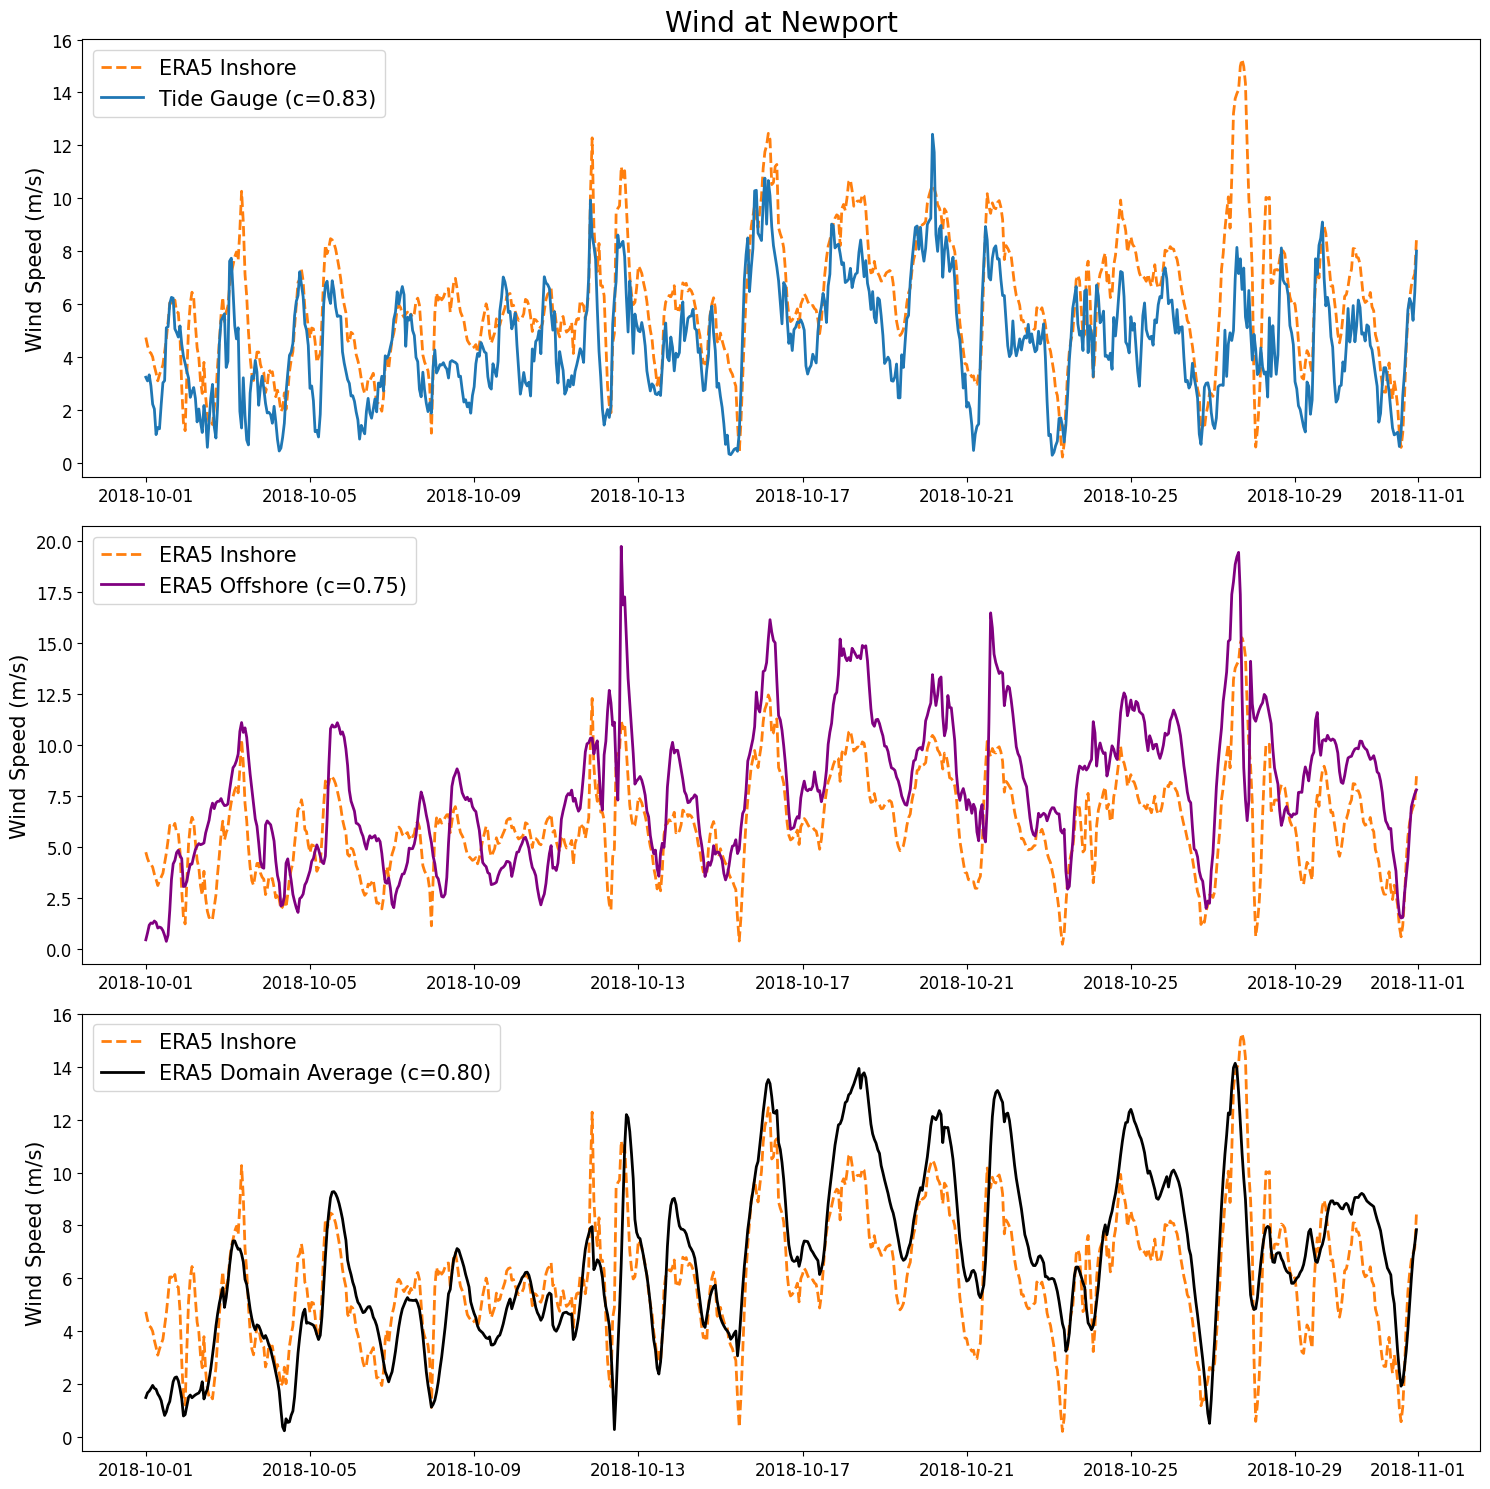

In [113]:
#%% select one month to plot
date_sel = '2018-10'
df3 = df2.loc[date_sel]

ref_var='era5_tg_W'
fig = plt.figure(figsize=(15, 15))
nrow=3;ncol=1

ax =  plt.subplot(nrow,ncol,1)
var = 'tg_W'
c = df2[[ref_var, var]].corr().loc[ref_var, var]
plt.plot(df3.index, df3[ref_var], label='ERA5 Inshore', 
         linewidth=2,
         color='tab:orange',linestyle='--')
plt.plot(df3.index, df3[var], label='Tide Gauge (c={:.2f})'.format(c), color='tab:blue',linewidth=2,)
plt.ylabel('Wind Speed (m/s)',fontsize=15)
plt.legend(loc='upper left',fontsize=15)
# plt.grid(True)
ax.tick_params(axis='both', labelsize=12)
plt.title('Wind at {}'.format(meta['name']),fontsize=20)
ax = plt.subplot(nrow,ncol,2)
var = 'era5_ooi_W'
c = df2[[ref_var, var]].corr().loc[ref_var, var]
plt.plot(df3.index, df3[ref_var], label='ERA5 Inshore', linewidth=2,color='tab:orange',linestyle='--')
plt.plot(df3.index, df3[var], label='ERA5 Offshore (c={:.2f})'.format(c), linewidth=2,color='purple')
# plt.title('Wind Speed - {}'.format(date_sel))
# plt.title('ERA5')
# plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)',fontsize=15)
plt.legend(loc='upper left',fontsize=15)
# plt.grid(True)
ax.tick_params(axis='both', labelsize=12)

ax = plt.subplot(nrow,ncol,3)
var = 'era5_avg_W'
c = df2[[ref_var, var]].corr().loc[ref_var, var]
plt.plot(df3.index, df3[ref_var], label='ERA5 Inshore', linewidth=2,color='tab:orange',linestyle='--')
plt.plot(df3.index, df3[var], label='ERA5 Domain Average (c={:.2f})'.format(c), linewidth=2,color='black')
plt.ylabel('Wind Speed (m/s)',fontsize=15)
plt.legend(loc='upper left',fontsize=15)
ax.tick_params(axis='both', labelsize=12)

# plt.grid(True)


plt.tight_layout()
plt.show()


In [114]:

fig.savefig(path_to_figures+'wind_ts.png',format='png',
            dpi=100,bbox_inches='tight')

In [115]:
import matplotlib.colors as mcolors
#%%
import cmocean as cm


In [116]:
#%% compute correlation of TG with ERA5 at each grid point


# Step 1: Compute ERA5 wind magnitude
dm['wind'] = np.sqrt(dm['u']**2 + dm['v']**2)

# Step 2: Align df and dm by time
# Subset dm to only the times in df to make sure they match
common_times = np.intersect1d(df.index.values, dm.time.values)
dm_matched = dm.sel(time=common_times)
df_matched = df.loc[common_times]

wind_insitu = np.array(df_matched['tg_W'].values)

# Step 3: Create empty correlation array
corr_array = np.full((dm.dims['latitude'], dm.dims['longitude']), np.nan)

# Step 4: Loop through each grid point and compute correlation
for i, lat in enumerate(dm.latitude.values):
    for j, lon in enumerate(dm.longitude.values):
        # Get the ERA5 wind time series at this grid cell
        wind_series = dm_matched['wind'][:, i, j].values

        # Only compute correlation if no NaNs
        if np.isnan(wind_series).any():
            continue

        # Compute Pearson correlation
        idx = np.isfinite(wind_insitu+wind_series)
        r, _ = pearsonr(wind_insitu[idx], wind_series[idx])

        corr_array[i, j] = r

# Step 5: Store result in a DataArray
corr_da = xr.DataArray(
    corr_array,
    dims=('latitude', 'longitude'),
    coords={'latitude': dm.latitude, 'longitude': dm.longitude},
    name='correlation'
)

/var/folders/hz/sc18rwnd4y3g63nhpsvlr_g80000gn/T/ipykernel_39275/2651198515.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  corr_array = np.full((dm.dims['latitude'], dm.dims['longitude']), np.nan)


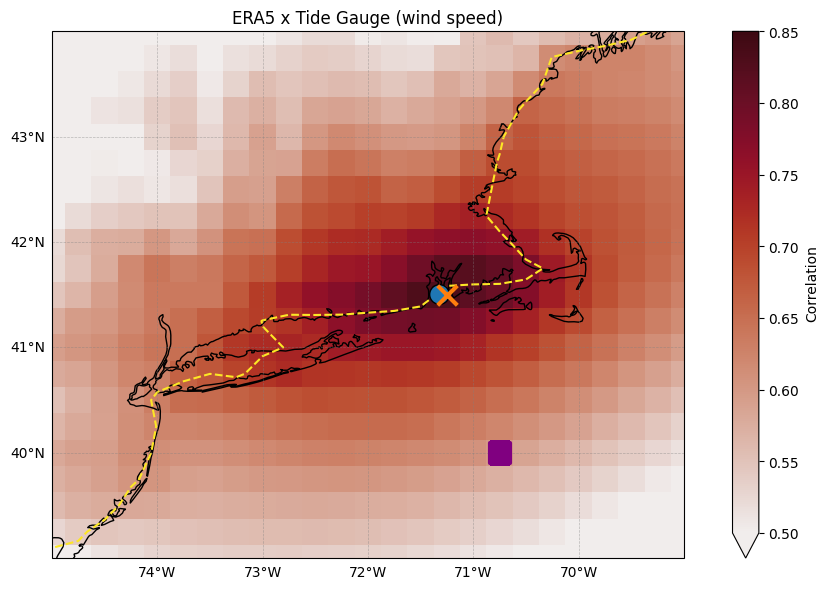

In [117]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
# dm[var][0,:,:].plot(ax=ax, transform=ccrs.PlateCarree(), 
#                       vmin=-10,vmax=10,cmap='RdBu_r')
# dm.mask.plot(ax=ax, transform=ccrs.PlateCarree(), 
#                       vmin=0,vmax=1)

corr_da.plot(ax=ax, transform=ccrs.PlateCarree(), 
             cmap=cm.cm.amp, vmin=0.5, vmax=0.85,
             cbar_kwargs={'label': 'Correlation'})

ds['lsm'][0,:,:].plot.contour(levels=[0.5],linestyles=['--'])
# Add coastlines
#% % 
ax.coastlines(facecolor='darkgray')

# cut region
# ax.set_extent([-73,-69,40,43])
ax.set_extent([-75, -69, 39, 44])
# Optionally, add more geographical features like borders, gridlines, etc.
# ax.add_feature(cfeature.BORDERS, linestyle='-',color='gray')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

#% scatter statiosn
ax.scatter(dm.longitude[era5_ooi_lon],dm.latitude[era5_ooi_lat],
            transform=ccrs.PlateCarree(), 
            s=200,
            zorder=10,
          marker='s',  # Open circle
                  color='purple',  # Optional: color for the edge of the marker
                  # facecolor='none',
                  linewidth=3  # Adjust the thickness of the edge

            )

ax.scatter(tg_lon,tg_lat,
           transform=ccrs.PlateCarree(), 
           s=200,
           zorder=10,
          marker='o',  # Open circle
                 color='tab:blue',  # Optional: color for the edge of the marker
                  # facecolor='none',
                  edgecolor='black',
                  # alpha=0.9,
                  linewidth=1  # Adjust the thickness of the edge

           )

ax.scatter(dm.longitude[era5_tg_lon],dm.latitude[era5_tg_lat],
           transform=ccrs.PlateCarree(), 
           s=200,
           zorder=10,
          marker='x',  # Open circle
                 color='tab:orange',  # Optional: color for the edge of the marker
                  # facecolor='none',
                  linewidth=3  # Adjust the thickness of the edge

           )
plt.title('ERA5 x Tide Gauge (wind speed)')
plt.tight_layout()

In [118]:
fig.savefig(path_to_figures+'corr_map.png',dpi=100)

In [119]:

#%% using stress

df = open_wind_csv(filename) # reload df

df['date']=pd.to_datetime(df['date'])
df.set_index('date',inplace=True)


df = df.resample('h').mean(numeric_only=True) # this will drop the direction (which we cant take the mean)

U = df['Speed'].values           # wind speed in m/s
theta_deg = df['Angle'].values  # wind direction in degrees (meteorological)

# Constants
rho_a = 1.225      # air density [kg/m^3]
C_d = 1.3e-3       # drag coefficient (can be refined)

# Convert to radians and rotate from meteorological to math convention
theta_rad = np.radians(270 - theta_deg)  # 0° = east, 90° = north

# Compute wind stress components
tau_x = rho_a * C_d * U**2 * np.cos(theta_rad)
tau_y = rho_a * C_d * U**2 * np.sin(theta_rad)

# Optionally add to DataFrame
df['tau_x'] = tau_x
df['tau_y'] = tau_y
df['tau_total'] = np.sqrt(df['tau_x']**2 + df['tau_y']**2)

#%% load era5 wind stress
path = '/Users/carocamargo/Documents/data/ERA5/'
file = 'wind_stress_mean_2014-2023.nc'

# file = 'wind_single_2013-2024.nc'

dm = xr.open_dataset(path+file)

file='mask.nc'
ds = xr.open_dataset(path+file)

# grid boxes where this parameter has a value above 0.5 can only be comprised of land 
# and those grid boxes with a value of 0.5 and below can only be comprised of ocean. 
mask = np.array(ds['lsm'].isel(valid_time=0))
mask[mask>0.5]=np.nan
mask[np.isfinite(mask)]=1
dm['mask']=(('latitude','longitude'),mask)
# dm['mask] = ds['lsm'].isel(valid_time=0)
# dm['mask'] = xr.where(dm['mask'] > 0.5, np.nan, 0)

# cut dm
bbox = [-75,-68,39,44]
dm = cut_ds(dm,bbox,lon_name='longitude',lat_name='latitude')
dm['tau_total'] = np.sqrt(dm['u']**2 + dm['v']**2)
#%% get time series 
dw = pd.DataFrame({'date':pd.to_datetime(dm.time),
                   # 'u':dm['u'][:,ilat,ilon],
                   # 'v':dm['v'][:,ilat,ilon],
                   })

dw['era5_tg_T'] = np.sqrt(dm['u'][:,era5_tg_lat,era5_tg_lon]**2+dm['v'][:,ilat,ilon]**2)
dw['era5_ooi_T'] = np.sqrt(dm['u'][:,era5_ooi_lat,era5_ooi_lon]**2+dm['v'][:,ilat,ilon]**2)

# print(dw)
# dw['date'] = pd.to_datetime(dw['date'])
dw.set_index('date', inplace=True)
#%% merge
df2 = df.join(dw[['era5_tg_T','era5_ooi_T']], how='inner')
#%% domain average
m = np.array(dm.mask)
m[np.isfinite(m)]=1
u = (dm['u'] * m).mean(dim=('latitude', 'longitude'), skipna=True)
v = (dm['v'] * m).mean(dim=('latitude', 'longitude'), skipna=True)

dw['era5_avg_T'] = np.sqrt(u**2+v**2)
# print(dw)
# dw['date'] = pd.to_datetime(dw['date'])
# dw.set_index('date', inplace=True)
#% %
df2 = df2.join(dw[['era5_avg_T']], how='inner')

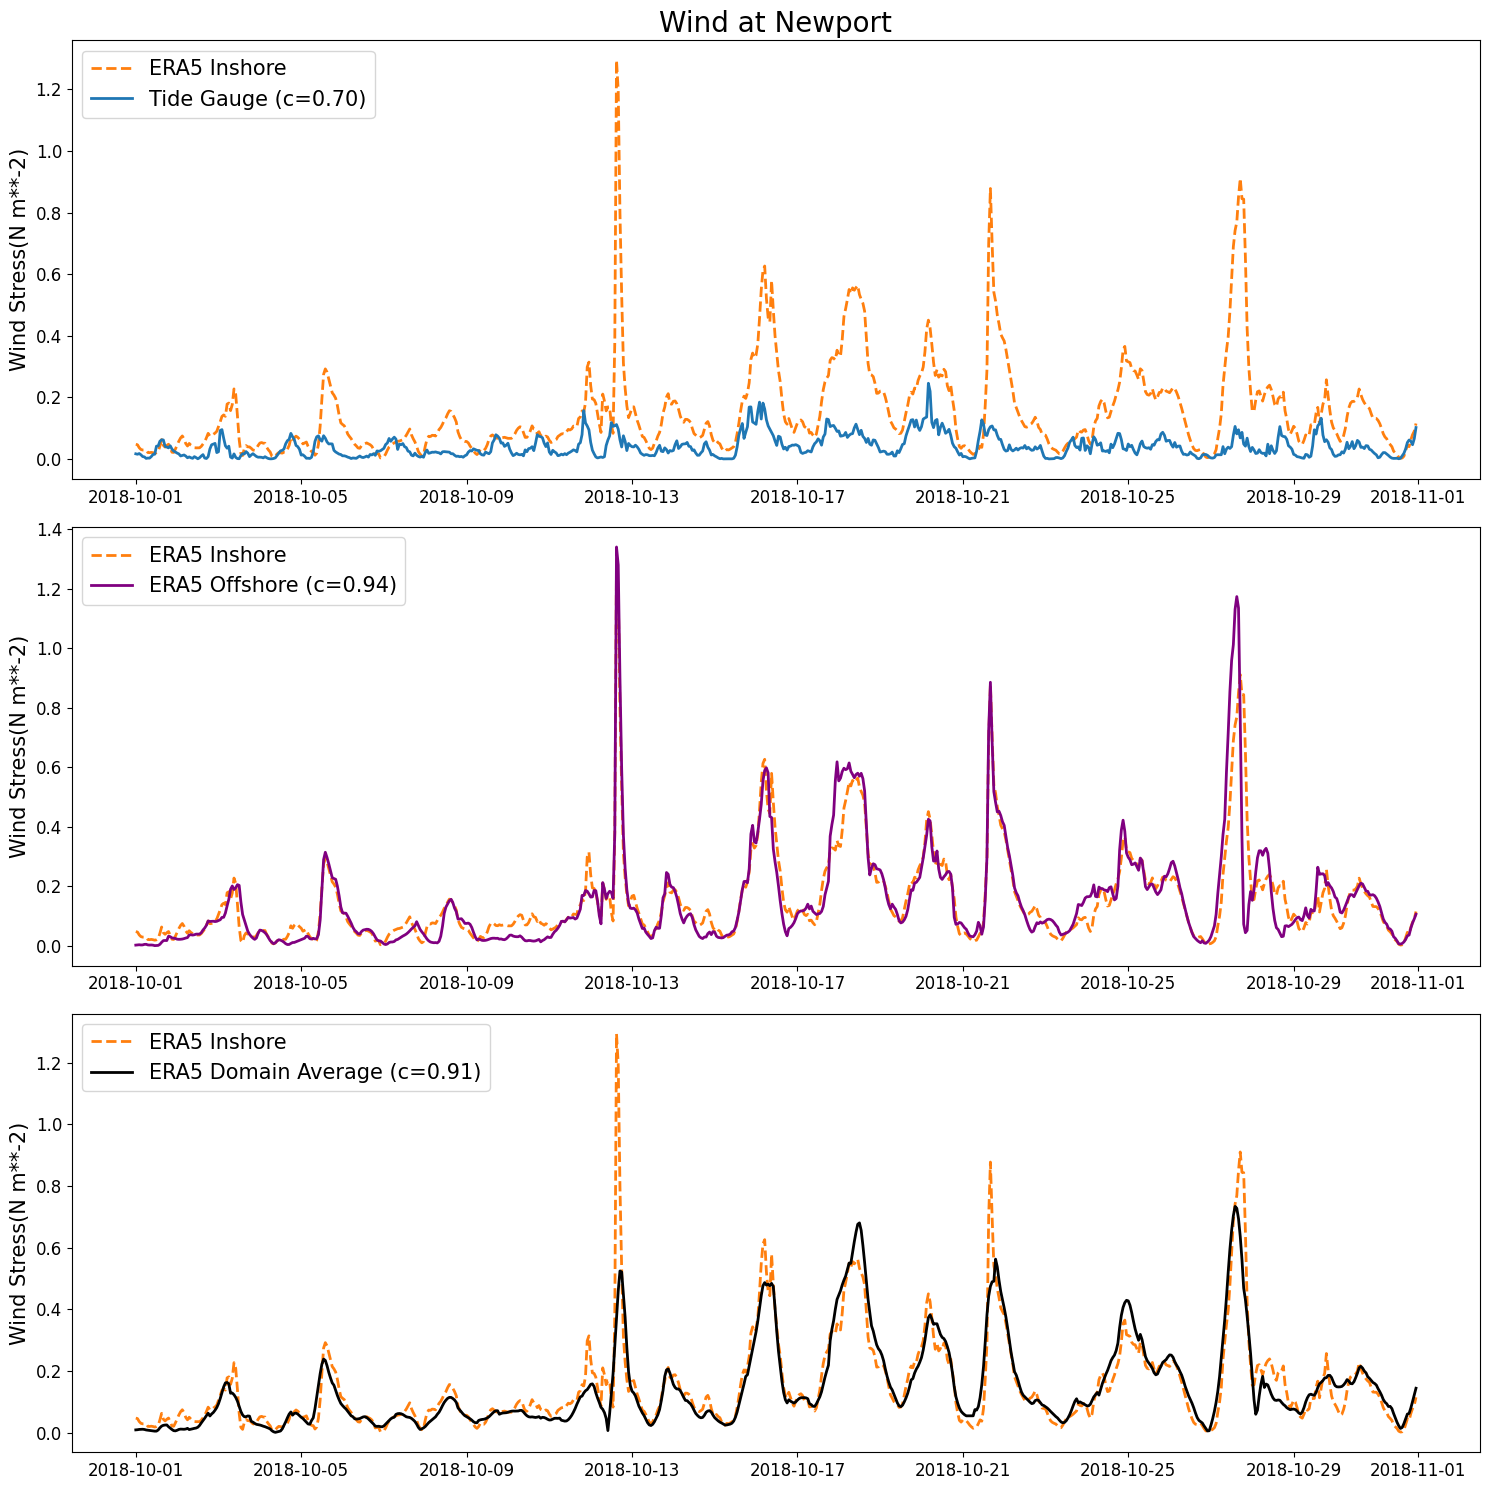

In [120]:
#%% plot time series stress
#% %  select one month to plot
date_sel = '2018-10'
df3 = df2.loc[date_sel]

ref_var='era5_tg_T'
fig = plt.figure(figsize=(15, 15))
nrow=3;ncol=1

ax =  plt.subplot(nrow,ncol,1)
var = 'tau_total'
c = df2[[ref_var, var]].corr().loc[ref_var, var]
plt.plot(df3.index, df3[ref_var], label='ERA5 Inshore', 
         linewidth=2,
         color='tab:orange',linestyle='--')
plt.plot(df3.index, df3[var], label='Tide Gauge (c={:.2f})'.format(c), color='tab:blue',linewidth=2,)
plt.ylabel('Wind Stress(N m**-2)',fontsize=15)
plt.legend(loc='upper left',fontsize=15)
# plt.grid(True)
ax.tick_params(axis='both', labelsize=12)
plt.title('Wind at {}'.format(meta['name']),fontsize=20)
ax = plt.subplot(nrow,ncol,2)
var = 'era5_ooi_T'
c = df2[[ref_var, var]].corr().loc[ref_var, var]
plt.plot(df3.index, df3[ref_var], label='ERA5 Inshore', linewidth=2,color='tab:orange',linestyle='--')
plt.plot(df3.index, df3[var], label='ERA5 Offshore (c={:.2f})'.format(c), linewidth=2,color='purple')
# plt.title('Wind Speed - {}'.format(date_sel))
# plt.title('ERA5')
# plt.xlabel('Date')
plt.ylabel('Wind Stress(N m**-2)',fontsize=15)
plt.legend(loc='upper left',fontsize=15)
# plt.grid(True)
ax.tick_params(axis='both', labelsize=12)

ax = plt.subplot(nrow,ncol,3)
var = 'era5_avg_T'
c = df2[[ref_var, var]].corr().loc[ref_var, var]
plt.plot(df3.index, df3[ref_var], label='ERA5 Inshore', linewidth=2,color='tab:orange',linestyle='--')
plt.plot(df3.index, df3[var], label='ERA5 Domain Average (c={:.2f})'.format(c), linewidth=2,color='black')
plt.ylabel('Wind Stress(N m**-2)',fontsize=15)
plt.legend(loc='upper left',fontsize=15)
ax.tick_params(axis='both', labelsize=12)

# plt.grid(True)


plt.tight_layout()
plt.show()


In [121]:
fig.savefig(path_to_figures+'wind_stress_ts.png',dpi=100)


In [122]:
#%% correlation map
common_times = np.intersect1d(df.index.values, dm.time.values)
dm_matched = dm.sel(time=common_times)
df_matched = df.loc[common_times]

wind_insitu = np.array(df_matched['tau_total'].values)

# Step 3: Create empty correlation array
corr_array = np.full((dm.dims['latitude'], dm.dims['longitude']), np.nan)

# Step 4: Loop through each grid point and compute correlation
for i, lat in enumerate(dm.latitude.values):
    for j, lon in enumerate(dm.longitude.values):
        # Get the ERA5 wind time series at this grid cell
        wind_series = dm_matched['tau_total'][:, i, j].values

        # Only compute correlation if no NaNs
        if np.isnan(wind_series).any():
            continue

        # Compute Pearson correlation
        idx = np.isfinite(wind_insitu+wind_series)
        r, _ = pearsonr(wind_insitu[idx], wind_series[idx])

        corr_array[i, j] = r

# Step 5: Store result in a DataArray
corr_da = xr.DataArray(
    corr_array,
    dims=('latitude', 'longitude'),
    coords={'latitude': dm.latitude, 'longitude': dm.longitude},
    name='correlation'
)




/var/folders/hz/sc18rwnd4y3g63nhpsvlr_g80000gn/T/ipykernel_39275/2692552981.py:9: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  corr_array = np.full((dm.dims['latitude'], dm.dims['longitude']), np.nan)


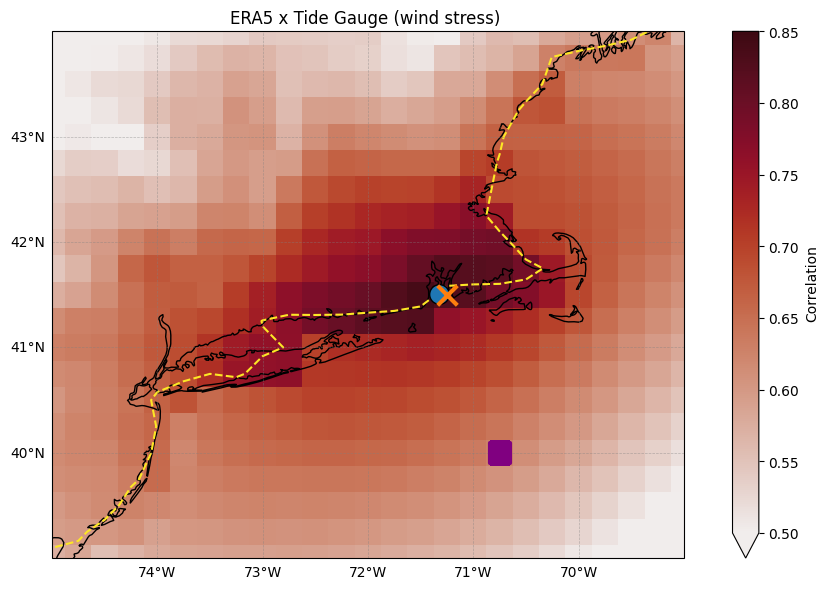

In [123]:
#%% plot

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
# dm[var][0,:,:].plot(ax=ax, transform=ccrs.PlateCarree(), 
#                       vmin=-10,vmax=10,cmap='RdBu_r')
# dm.mask.plot(ax=ax, transform=ccrs.PlateCarree(), 
#                       vmin=0,vmax=1)

corr_da.plot(ax=ax, transform=ccrs.PlateCarree(), 
             cmap=cm.cm.amp, vmin=0.5, vmax=0.85,
             cbar_kwargs={'label': 'Correlation'})

ds['lsm'][0,:,:].plot.contour(levels=[0.5],linestyles=['--'])
# Add coastlines
#% % 
ax.coastlines(facecolor='darkgray')

# cut region
# ax.set_extent([-73,-69,40,43])
ax.set_extent([-75, -69, 39, 44])
# Optionally, add more geographical features like borders, gridlines, etc.
# ax.add_feature(cfeature.BORDERS, linestyle='-',color='gray')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

#% scatter statiosn
ax.scatter(dm.longitude[era5_ooi_lon],dm.latitude[era5_ooi_lat],
            transform=ccrs.PlateCarree(), 
            s=200,
            zorder=10,
          marker='s',  # Open circle
                  color='purple',  # Optional: color for the edge of the marker
                  # facecolor='none',
                  linewidth=3  # Adjust the thickness of the edge

            )

ax.scatter(tg_lon,tg_lat,
           transform=ccrs.PlateCarree(), 
           s=200,
           zorder=10,
          marker='o',  # Open circle
                 color='tab:blue',  # Optional: color for the edge of the marker
                  # facecolor='none',
                  edgecolor='black',
                  # alpha=0.9,
                  linewidth=1  # Adjust the thickness of the edge

           )

ax.scatter(dm.longitude[era5_tg_lon],dm.latitude[era5_tg_lat],
           transform=ccrs.PlateCarree(), 
           s=200,
           zorder=10,
          marker='x',  # Open circle
                 color='tab:orange',  # Optional: color for the edge of the marker
                  # facecolor='none',
                  linewidth=3  # Adjust the thickness of the edge

           )
plt.title('ERA5 x Tide Gauge (wind stress) ')
plt.tight_layout()

plt.show()


In [124]:
fig.savefig(path_to_figures+'corr_stress_map.png',dpi=100)

Above figures are combined on PPT to give SI figures. 

# SL Distribution & Flood days 

see also flood_hist2.py

In [125]:
station_id = '8443970'# , # boston

datum = 'MHHW'
y1 = 1933
y2 = 2003
download = False
f1 = "/Users/carocamargo/Documents/data/sealevel/NOAA/Boston_{}_{}.plk".format(
        y1,datum)
f2 = "/Users/carocamargo/Documents/data/sealevel/NOAA/Boston_{}_{}.plk".format(
    y2,datum)
f3 = "/Users/carocamargo/Documents/data/sealevel/NOAA/Boston_1970-2020_MHHW.pkl"


if download:
    df1 = noaaSeaLevelLoop(station_id, y1,y1+20, datum=datum)
    df1.to_pickle(f1) 
    
    df2 = noaaSeaLevelLoop(station_id, y2,y2+20, datum=datum)
    df2.to_pickle(f2) 
    
    #% % download and save form 1970 yo 2020
    df3 = noaaSeaLevelLoop(station_id, 1970,2020, datum=datum)
    df3.to_pickle(f3) 
else: # open
    df1 = pd.read_pickle(f1)
    df2 = pd.read_pickle(f2)
    df3 = pd.read_pickle(f3)

In [127]:
from utils_work import noaaFlood, noaaDatum

In [128]:
#%% thresholds
thres = noaaFlood(station_id,datum=datum,
                   # metric=True
                   )
dat_dict = noaaDatum(station_id)

In [129]:
#%% create future time series
# https://tidesandcurrents.noaa.gov/sltrends/sltrends_station.shtml?id=8443970#tabmeantrend
# by multiplying SLR rate over the observational period
rate = 2.97 # mm/y # Boston
# rate = 3.13 # Woods Hole 
rate = rate/1000
# for the next 50 years
years = 50
df2['future'] = df2['value'] + rate*years


In [130]:
#%% Daily 
df1.set_index('date',inplace=True)
df2.set_index('date',inplace=True)
#%%
dd1 = df1.resample('1D').max()
dd2 = df2.resample('1D').max()

In [131]:
# 1. Convert 'date' to datetime and decimal year
df3['date'] = pd.to_datetime(df3['date'])
df3['year_decimal'] = df3['date'].dt.year + (df3['date'].dt.dayofyear - 1 + df3['date'].dt.hour / 24) / 365.25

# 2. Fit linear and quadratic models
x = df3['year_decimal'].values
y = df3['value'].values

# Drop rows with NaNs in either year_decimal or value
mask = ~df3[['year_decimal', 'value']].isna().any(axis=1)
x = df3.loc[mask, 'year_decimal'].values
y = df3.loc[mask, 'value'].values

# Linear: degree 1, Quadratic: degree 2
linear_coeffs = np.polyfit(x, y, deg=1)
quad_coeffs = np.polyfit(x, y, deg=2)

# 3. Create hourly timestamps from 2021-01-01 to 2100-12-31
future_dates = pd.date_range(start='2021-01-01', end='2100-12-31 23:00:00', freq='h')
future_years = future_dates.year + (future_dates.dayofyear - 1 + future_dates.hour / 24) / 365.25

# 4. Predict values using fitted models
linear_pred = np.polyval(linear_coeffs, future_years)
quad_pred = np.polyval(quad_coeffs, future_years)

# 5. Create new DataFrames with predictions
df_lin = pd.DataFrame({'date': future_dates, 'value': linear_pred, 
                       'year':future_years})
df_quad = pd.DataFrame({'date': future_dates, 'value': quad_pred,
                        'year':future_years})

#%% add trends to obs from 2003-2023
years = 50
df2['lin'] = df2['value'] + linear_coeffs[0]*years
df2['quad'] = df2['value'] + quad_coeffs[0]*years + years**quad_coeffs[1]


In [132]:
dd2 = df2.resample('1D').max()

n2 = len(dd2[dd2['value']>thres['nos_minor']])
n1 = len(dd1[dd1['value']>thres['nos_minor']])
n3 = len(dd2[dd2['future']>thres['nos_minor']])

n6 = len(dd2[dd2['lin']>thres['nos_minor']])
n7 = len(dd2[dd2['quad']>thres['nos_minor']])

print('Number of floods for the period')
print('from {}-{}: {} floods'.format(y1,y1+20,n1))
print('from {}-{}: {} floods'.format(y2,y2+20,n2))
print('from {}-{} (pres. day rate): {} floods'.format(y2+years+20,y2+20+years+20,n3))

print('from {}-{} (lin ext 1970-2020): {} floods'.format(y2+years+20,y2+20+years+20,n6))
print('from {}-{} (quad ext 1970-2020): {} floods'.format(y2+years+20,y2+20+years+20,n7))
#%%

Number of floods for the period
from 1933-1953: 27 floods
from 2003-2023: 221 floods
from 2073-2093 (pres. day rate): 688 floods
from 2073-2093 (lin ext 1970-2020): 783 floods
from 2073-2093 (quad ext 1970-2020): 1451 floods


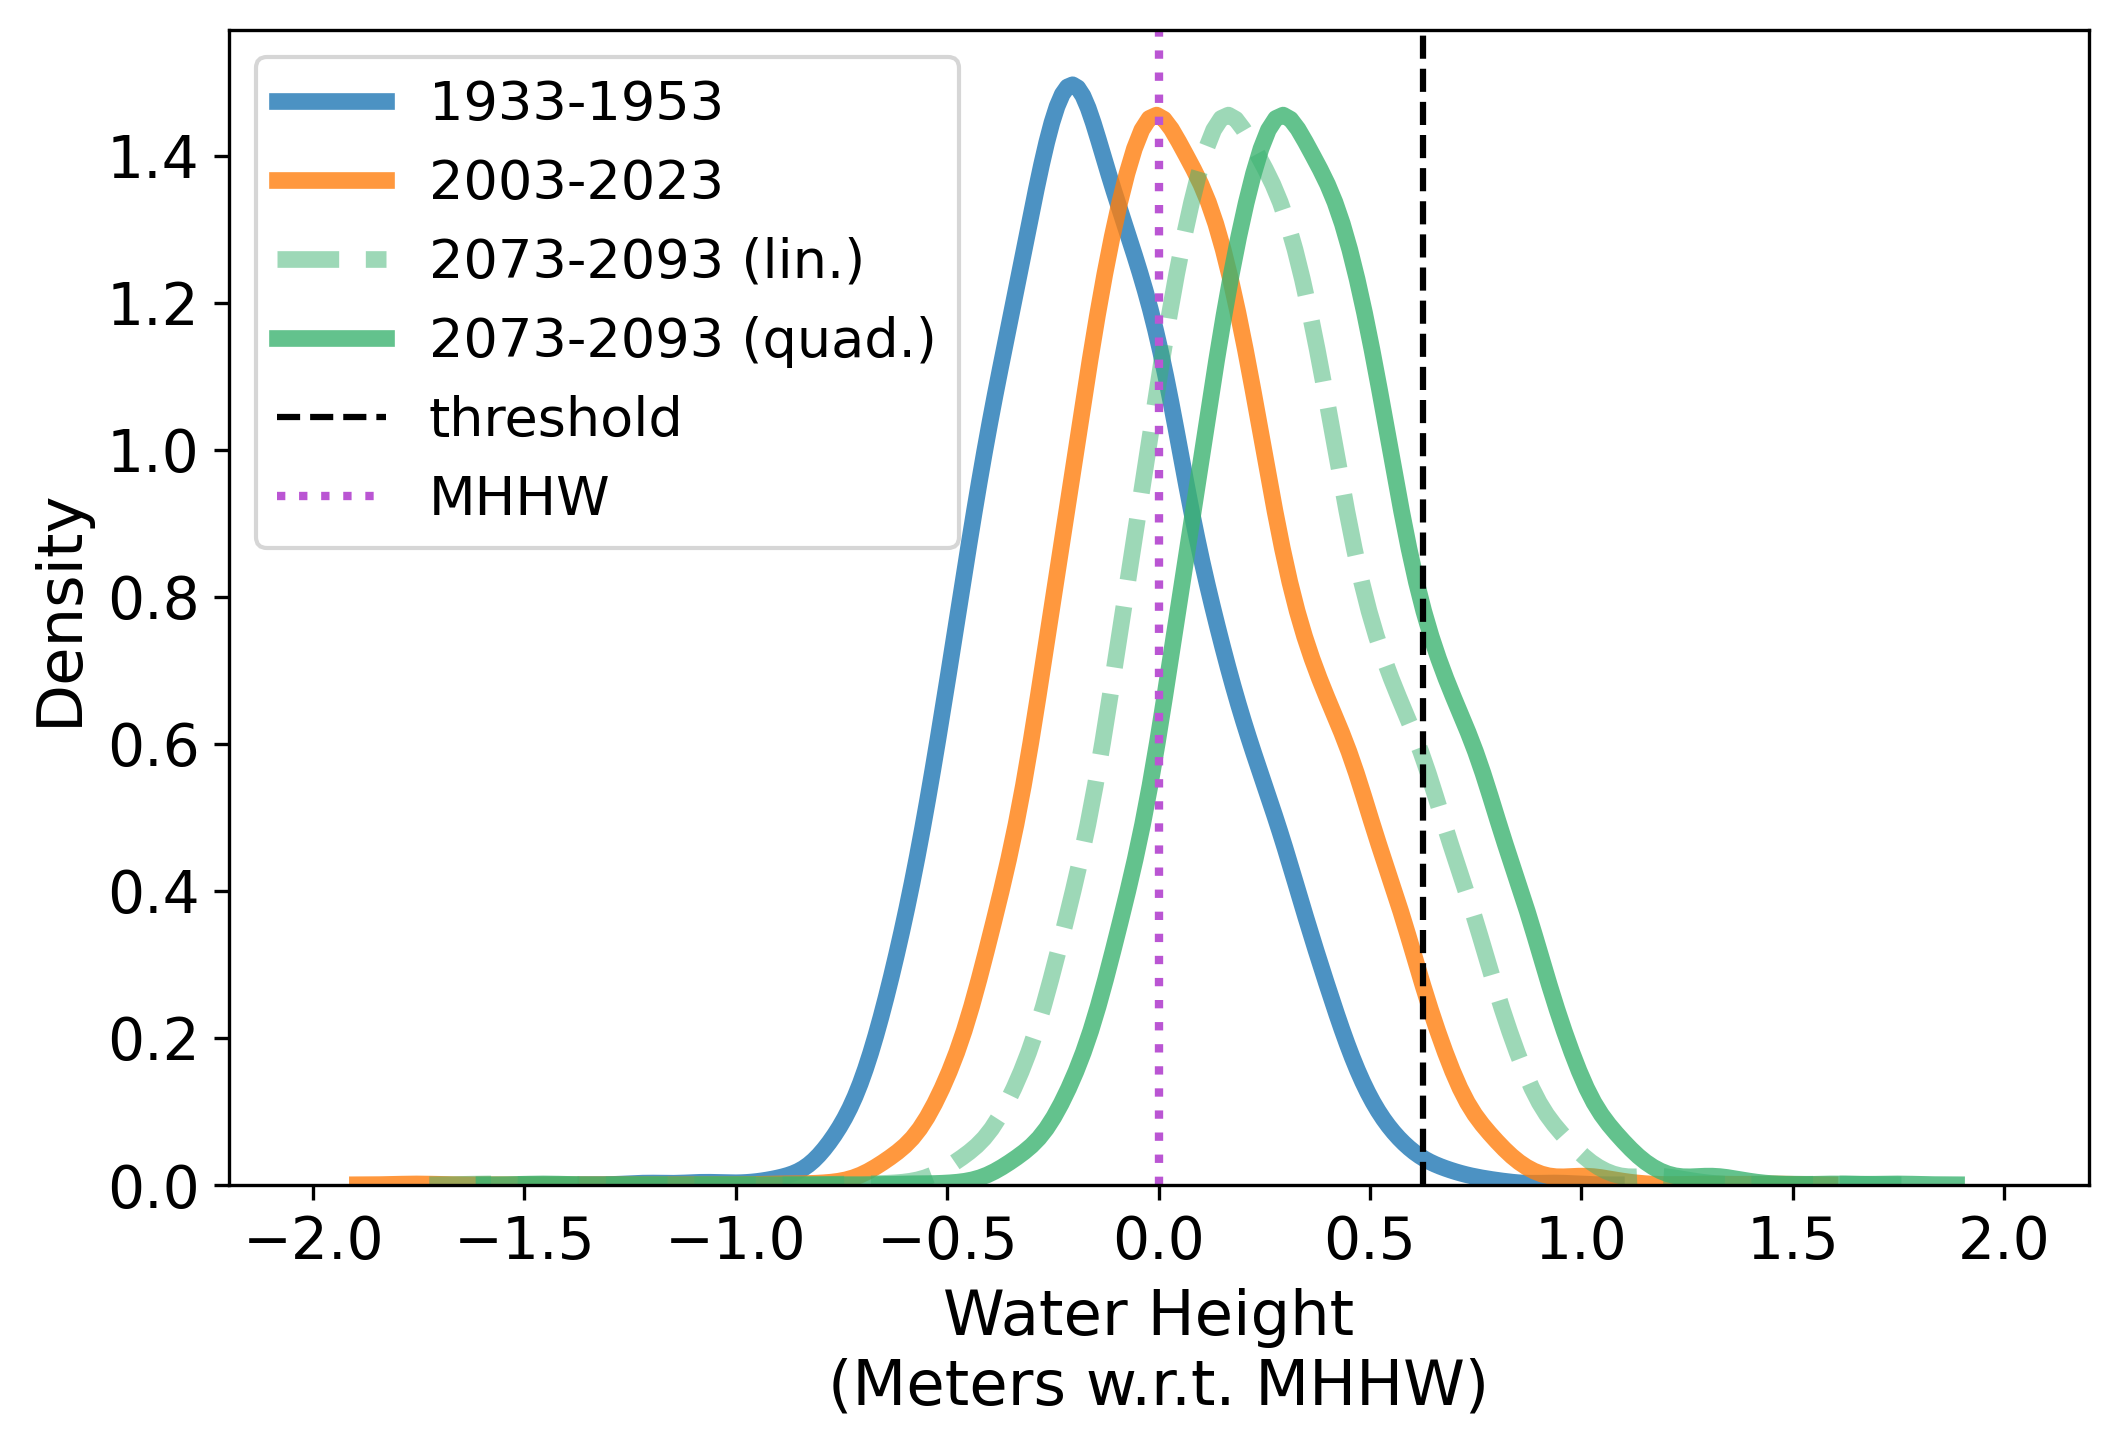

In [133]:
fig = plt.figure(figsize=(8, 5),dpi=300)
ax=plt.subplot(111)
# plt.title('{} \n{}-{}: {} floods \n {}-{}: {} floods'.format(meta['name'], 
#                                                              y1,y1+20,n1,y2,y2+20,n2,
#                                                              ))
# plt.title(meta['name'],fontsize=18)
sns.kdeplot(dd1['value'], label='{}-{}'.format(y1,y1+20), alpha=0.8,linewidth=4)
sns.kdeplot(dd2['value'], label='{}-{}'.format(y2,y2+20), alpha=0.8,linewidth=4)
sns.kdeplot(dd2['lin'], 
            # label='{}-{} ({:.2f} mm/yr)'.format(
            # y2+years+20,y2+20+years+20,rate*1000), 
            label = '2073-2093 (lin.)',
            alpha=0.5,
            linestyle='--',color='mediumseagreen',
            # edgecolor=None,
            # fill=True,
            linewidth=4)
sns.kdeplot(dd2['quad'], 
            label='2073-2093 (quad.)',
            # label='{}-{} ({:.2f} mm/yr)'.format(
            # y2+years+20,y2+20+years+20,rate_intlow*1000), 
            alpha=0.8,
            linestyle='-', color='mediumseagreen',
            # fill=True,
            linewidth=4)
# sns.kdeplot(dd2['future_inthigh'], 
#             # label='{}-{} ({:.2f} mm/yr)'.format(
#             # y2+years+20,y2+20+years+20,rate_inthigh*1000), 
#             label = '2073-2093 (high)',
#             alpha=0.5,
#             linestyle=':',color='mediumseagreen',
#             # fill=True,
#             # edgecolor=None,
#             linewidth=4)


plt.axvline(thres['nos_minor'],c='black',linestyle='--',label='threshold')
# plt.axvline(thres['nws_minor'],c='black',linestyle=':',label='nws minor')
colors =[# 'thistle',
         'mediumorchid','violet']
for i,key in enumerate([# 'MLLW',
                        'MHHW',
                          # 'MSL'
                        ]): # dat_dict.keys():
    
    plt.axvline(dat_dict[key]['value'] - dat_dict[datum]['value'],
                linestyle=':',linewidth=2,
                c=colors[i],
                label=key)
# plt.axvline(dat_dict['MHHW']['value'])
plt.xlabel('Water Height \n(Meters w.r.t. MHHW)',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.xlim(-2.2,2.2)
plt.legend(ncol=1,loc='upper left',fontsize=13)
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=3,fontsize=14)

ax.tick_params(axis='both', labelsize=14)  # Adjust 'labelsize' as needed

plt.show()

In [134]:
kurs=path_to_figures+'baseline_daymax_ext.png'
            
fig.savefig(kurs,format='png',dpi=300,bbox_inches='tight')